# Libraries

In [270]:
import pickle
import random
import pandas as pd
import numpy as np
from IPython.display import Image
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn.preprocessing import MinMaxScaler
from boruta import BorutaPy
from sklearn.ensemble import ExtraTreesClassifier
from collections import Counter
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, cohen_kappa_score, roc_curve, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from imblearn import over_sampling as oversamp
from sklearn import preprocessing as pp
from scipy.stats import chi2_contingency 
from sklearn import metrics as m
from scikitplot import metrics as mt
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

# Helper Functions

In [120]:
# instantiates the utilities object
#gu = Utilities()

# disable max columns limit
pd.set_option('display.max_columns', 70)

# sets to not crop long vlaues for rows
pd.set_option("display.max_colwidth", 70)

# sets format to suppress scientific notation
pd.options.display.float_format = '{:,.2f}'.format

# sets seaborn default style
sns.set()

# sets global SEED
SEED = 42

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y).values
    n = confusion_matrix.sum()
    r,k = confusion_matrix.shape
    
    chi2 = chi2_contingency(confusion_matrix)[0]
    phi2 = chi2/n
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# Loading Data

In [3]:
pwd

'/Users/lucasquemelli/Documents/repos/cardio_catch_disease'

In [4]:
data = pd.read_csv('/Users/lucasquemelli/Documents/repos/cardio_catch_disease/cardio_train.csv')
data.head()

id;age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active;cardio
0                                  0;18393;2;168;62.0;110;80;1;1;0;0;1;0           
1                                  1;20228;1;156;85.0;140;90;3;1;0;0;1;1           
2                                  2;18857;1;165;64.0;130;70;3;1;0;0;0;1           
3                                 3;17623;2;169;82.0;150;100;1;1;0;0;1;1           
4                                  4;17474;1;156;56.0;100;60;1;1;0;0;0;0

In [5]:
data = pd.read_csv('/Users/lucasquemelli/Documents/repos/cardio_catch_disease/cardio_train.csv', sep=';')
data.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168   62.00    110     80            1     1      0   
1   1  20228       1     156   85.00    140     90            3     1      0   
2   2  18857       1     165   64.00    130     70            3     1      0   
3   3  17623       2     169   82.00    150    100            1     1      0   
4   4  17474       1     156   56.00    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

# 1. Data Description

In [6]:
df1 = data.copy()

## 1.1. Data Fields Meaning

There are 3 types of input features:

1. Objective: factual information;
2. Examination: results of medical examination;
3. Subjective: information given by the patient.

Features:

- Age | Objective Feature | age | int (days)
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code |
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

## 1.2. Data Dimensions

In [7]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 70000
Number of cols: 13


## 1.3. Data Types

In [8]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [10]:
df1.head(3)

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168   62.00    110     80            1     1      0   
1   1  20228       1     156   85.00    140     90            3     1      0   
2   2  18857       1     165   64.00    130     70            3     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1

### 1.3.1. Data Conversion

In [11]:
df1["age"] = df1["age"].apply(lambda x: round(x/365))
df1.head(3)

id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0   50       2     168   62.00    110     80            1     1      0   
1   1   55       1     156   85.00    140     90            3     1      0   
2   2   52       1     165   64.00    130     70            3     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1

## 1.4. NA Check

In [12]:
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [13]:
df1.isna().sum()/len(df1)

id            0.00
age           0.00
gender        0.00
height        0.00
weight        0.00
ap_hi         0.00
ap_lo         0.00
cholesterol   0.00
gluc          0.00
smoke         0.00
alco          0.00
active        0.00
cardio        0.00
dtype: float64

<AxesSubplot:>

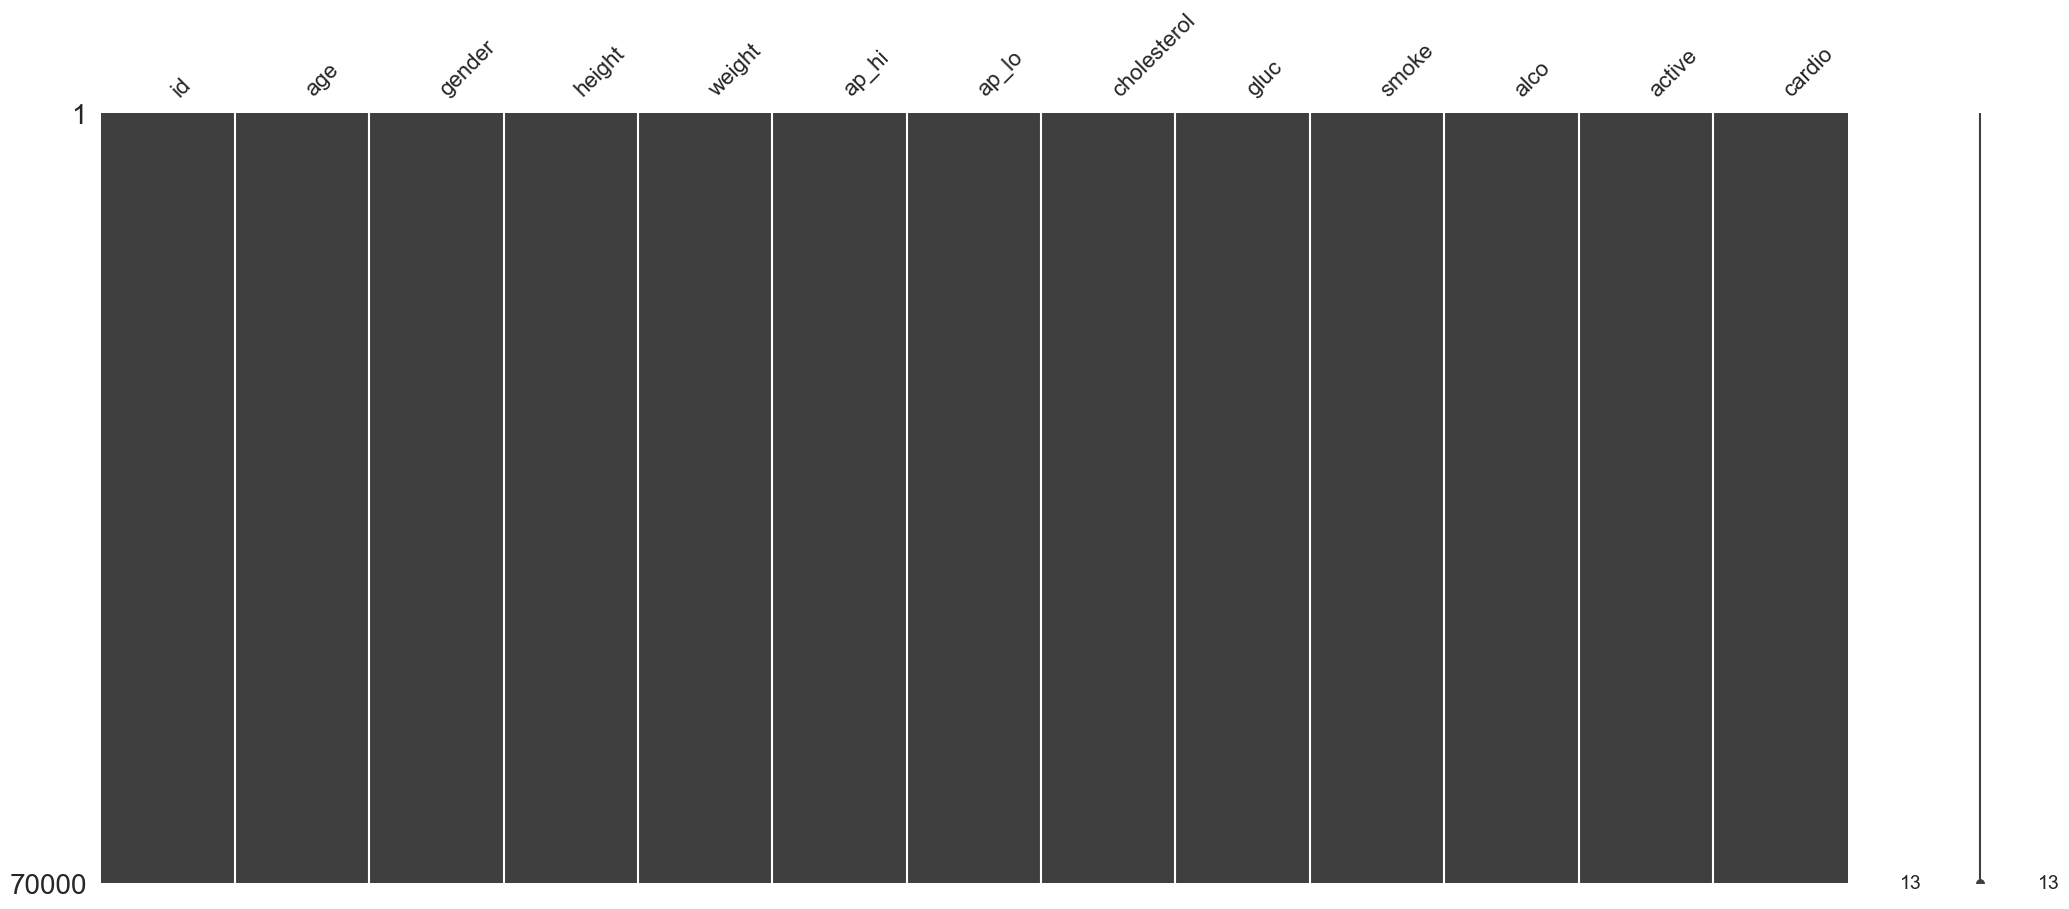

In [14]:
# Visualizing the missing values
msno.matrix(df1)

- 70000 rows.
- 13 columns.
- No missing values.

## 1.6. Descriptive Statistics

This section is to find inconsistencies and anomalies and also the main characteristics of our data.

In [15]:
df1.drop(columns="id").describe().T

count   mean    std     min    25%    50%    75%       max
age         70,000.00  53.34   6.77   30.00  48.00  54.00  58.00     65.00
gender      70,000.00   1.35   0.48    1.00   1.00   1.00   2.00      2.00
height      70,000.00 164.36   8.21   55.00 159.00 165.00 170.00    250.00
weight      70,000.00  74.21  14.40   10.00  65.00  72.00  82.00    200.00
ap_hi       70,000.00 128.82 154.01 -150.00 120.00 120.00 140.00 16,020.00
ap_lo       70,000.00  96.63 188.47  -70.00  80.00  80.00  90.00 11,000.00
cholesterol 70,000.00   1.37   0.68    1.00   1.00   1.00   2.00      3.00
gluc        70,000.00   1.23   0.57    1.00   1.00   1.00   1.00      3.00
smoke       70,000.00   0.09   0.28    0.00   0.00   0.00   0.00      1.00
alco        70,000.00   0.05   0.23    0.00   0.00   0.00   0.00      1.00
active      70,000.00   0.80   0.40    0.00   1.00   1.00   1.00      1.00
cardio      70,000.00   0.50   0.50    0.00   0.00   0.00   1.00      1.00

Since we have no categorical features, let's just create a numerical dataset without id column:

In [16]:
num_attributes = df1.drop(columns="id").select_dtypes(include=['int64', 'float64'])

### 1.6.1. Numerical Attributes

In [17]:
# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenar
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

attributes     min       max     range   mean  median    std  skew  \
0           age   30.00     65.00     35.00  53.34   54.00   6.77 -0.31   
1        gender    1.00      2.00      1.00   1.35    1.00   0.48  0.63   
2        height   55.00    250.00    195.00 164.36  165.00   8.21 -0.64   
3        weight   10.00    200.00    190.00  74.21   72.00  14.40  1.01   
4         ap_hi -150.00 16,020.00 16,170.00 128.82  120.00 154.01 85.30   
5         ap_lo  -70.00 11,000.00 11,070.00  96.63   80.00 188.47 32.11   
6   cholesterol    1.00      3.00      2.00   1.37    1.00   0.68  1.59   
7          gluc    1.00      3.00      2.00   1.23    1.00   0.57  2.40   
8         smoke    0.00      1.00      1.00   0.09    0.00   0.28  2.91   
9          alco    0.00      1.00      1.00   0.05    0.00   0.23  3.96   
10       active    0.00      1.00      1.00   0.80    1.00   0.40 -1.53   
11       cardio    0.00      1.00      1.00   0.50    0.00   0.50  0.00   

    kurtosis  
0      -0.82  
1      -1.60  
2       7.94  
3       2.59  
4   7,580.07  
5   1,425.91  
6       0.99  
7       4.29  
8       6.44  
9      13.66  
10      0.34  
11     -2.00

- From the table above, we may see that we have strong skewness to the left for ap_ho and for ap_lo. 
- The two columns also presented a high peak for their distribution, since we have high values for kurtosis.
- We expected the skewness for the two columns mentioned because they the ones which the mean and the median most vary from each other.
- 250 cm as the maximum height is not possible.
- Minimum value for height of 55 cm is totally possible. 

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


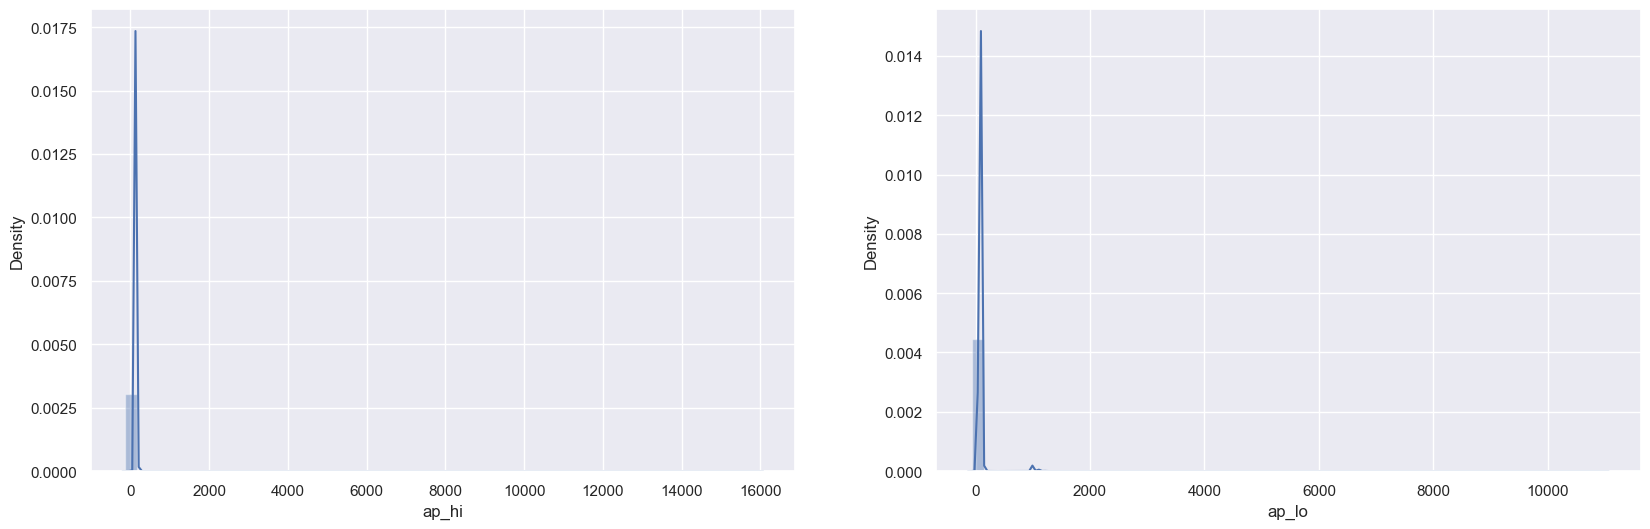

In [18]:
plt.figure(figsize = (20,6))

plt.subplot(121)
sns.distplot(df1["ap_hi"])

plt.subplot(122)
sns.distplot(df1["ap_lo"])

plt.subplots_adjust(wspace = 0.2)

We probably had a left skew because of the maximum values for these variables. Let's see how the distribution is without values higher than those found in 75% (third quartile).

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


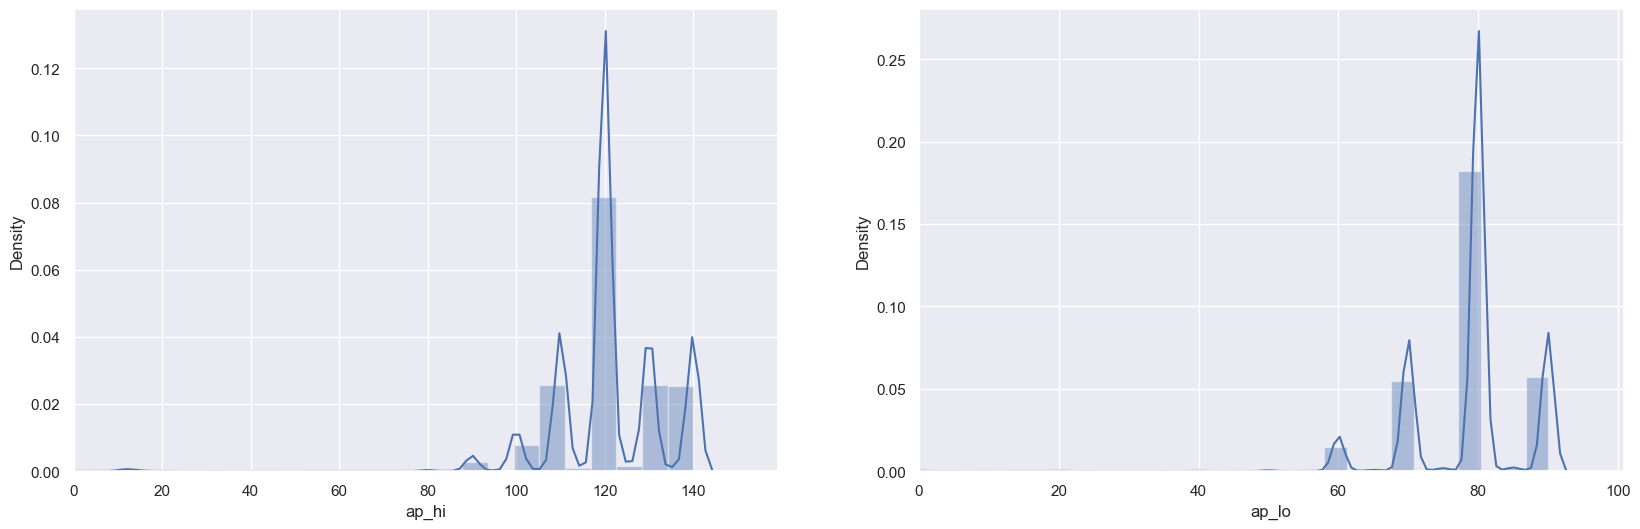

In [19]:
aux = df1[(df1["ap_hi"] <= 140) & (df1["ap_lo"] <= 90)]

plt.figure(figsize = (20,6))

plt.subplot(121)
sns.distplot(aux["ap_hi"])
plt.xlim(0, )

plt.subplot(122)
sns.distplot(aux["ap_lo"])
plt.xlim(0, )

plt.subplots_adjust(wspace = 0.2)

In [20]:
# Selecting data considering the analysis
df1 = df1[(df1["height"] < 250) & (df1["ap_hi"] <= 140) & (df1["ap_lo"] <= 90)]

## 1.7. Checking Outliers

### 1.7.1. Skewness and Kurtosis Classification

Besides the data cleaning we made above, it is still to check outliers in the dataset. Let's classify skewness and kurtosis. 

- Nearly symmetric: Skewness values between -0.5 and 0.5 indicate a nearly symmetric distribution.
- Moderately skewed: Skewness values between -1 and -0.5 or between 0.5 and 1 indicate a moderately skewed distribution.
- Highly skewed: Skewness values less than -1 or greater than 1 indicate a highly skewed distribution.

- The range of values for a classification as heavy tail in terms of kurtosis depends on the specific field or discipline and the context in which it is being used. Generally speaking, kurtosis measures the heaviness of the tails of a probability distribution relative to a normal distribution. A kurtosis value of 3 indicates that the distribution has the same tail weight as a normal distribution, while values greater than 3 indicate heavier tails (in general).

In [21]:
# creating a copied dataframe
summary_stats = ct.copy()

# classifies skwewness
summary_stats['skwewness_class'] = summary_stats['skew'].apply(lambda x: 
                                                               'nearly symmetric' if (((x > 0) & (x < 0.5)) | ((x < 0) & (x > -0.5))) 
                                                                else 'moderately skewed' if (((x > 0.5) & (x < 1.0)) | ((x < -0.5) & (x > -1.0))) 
                                                                else 'highly skewed')

# classifies kurtosis
summary_stats['kurtosis_class'] = summary_stats['kurtosis'].apply(lambda x:
                                                                 'heavy tails' if (x > 3) 
                                                                  else 'light tails')

# checks operations
summary_stats

attributes     min       max     range   mean  median    std  skew  \
0           age   30.00     65.00     35.00  53.34   54.00   6.77 -0.31   
1        gender    1.00      2.00      1.00   1.35    1.00   0.48  0.63   
2        height   55.00    250.00    195.00 164.36  165.00   8.21 -0.64   
3        weight   10.00    200.00    190.00  74.21   72.00  14.40  1.01   
4         ap_hi -150.00 16,020.00 16,170.00 128.82  120.00 154.01 85.30   
5         ap_lo  -70.00 11,000.00 11,070.00  96.63   80.00 188.47 32.11   
6   cholesterol    1.00      3.00      2.00   1.37    1.00   0.68  1.59   
7          gluc    1.00      3.00      2.00   1.23    1.00   0.57  2.40   
8         smoke    0.00      1.00      1.00   0.09    0.00   0.28  2.91   
9          alco    0.00      1.00      1.00   0.05    0.00   0.23  3.96   
10       active    0.00      1.00      1.00   0.80    1.00   0.40 -1.53   
11       cardio    0.00      1.00      1.00   0.50    0.00   0.50  0.00   

    kurtosis    skwewness_class kurtosis_class  
0      -0.82   nearly symmetric    light tails  
1      -1.60  moderately skewed    light tails  
2       7.94  moderately skewed    heavy tails  
3       2.59      highly skewed    light tails  
4   7,580.07      highly skewed    heavy tails  
5   1,425.91      highly skewed    heavy tails  
6       0.99      highly skewed    light tails  
7       4.29      highly skewed    heavy tails  
8       6.44      highly skewed    heavy tails  
9      13.66      highly skewed    heavy tails  
10      0.34      highly skewed    light tails  
11     -2.00   nearly symmetric    light tails

The features with a distribution that is highly skewed with heavy tails are:

1. ap_hi.
2. ap_lo.
3. gluc.
4. smoke.
5. alco.

This means that there are many data far from the mean. They could be outliers.

### 1.7.2. Scatterplot Classification

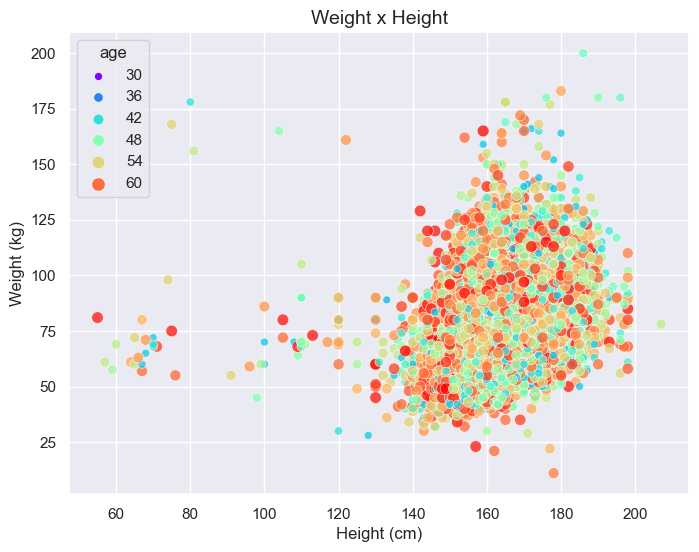

In [22]:
# sets plot size
plt.figure(figsize=(8,6))

# plots scatterplot
sns.scatterplot(x='height', y='weight', data=df1, hue='age', palette='rainbow', size='age', alpha=0.75)
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")
plt.title("Weight x Height", fontsize=14)

# displays the plot
plt.show()

May be outliers:

- Height lower than 120 cm.
- Weight above 150 kg and below 25 kg.

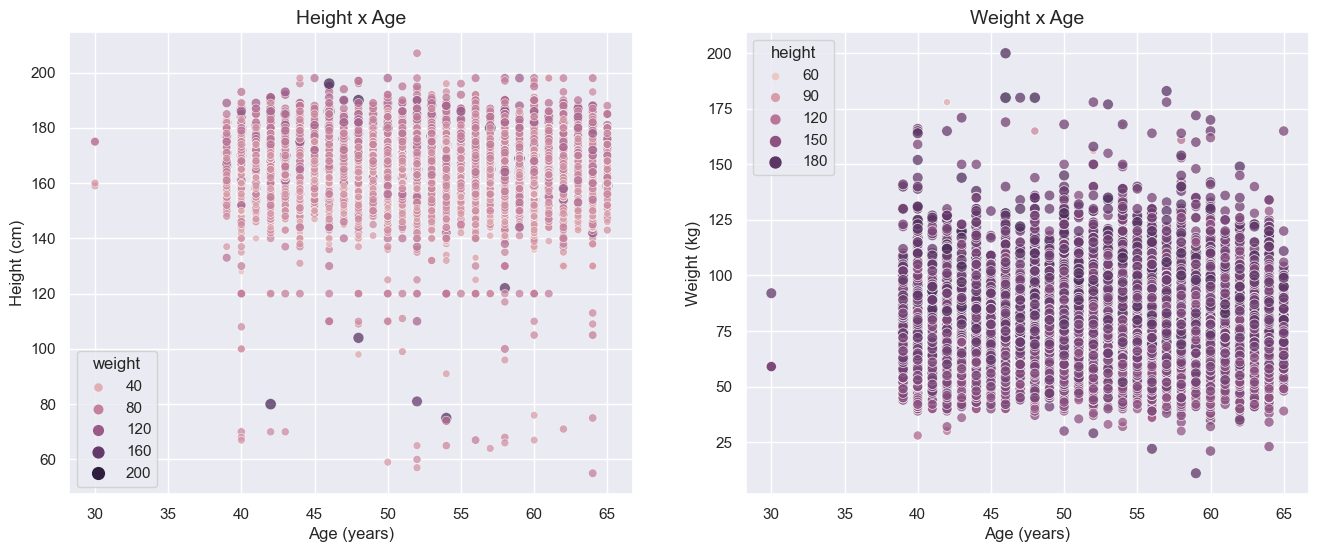

In [23]:
# sets plot size
plt.figure(figsize=(16,6))

# plots scatterplot
plt.subplot(1,2,1)
sns.scatterplot(x='age', y='height', data=df1, hue='weight', size='weight', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Height (cm)")
plt.title("Height x Age", fontsize=14)

# plots scatterplot
plt.subplot(1,2,2)
sns.scatterplot(x='age', y='weight', data=df1, hue='height', size='height', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Weight (kg)")
plt.title("Weight x Age", fontsize=14)

# displays the plot
plt.show()

As we mentioned above, outliers may be:

- Height lower than 120 cm. 
- Weight below 25 kg and above 150 kg.

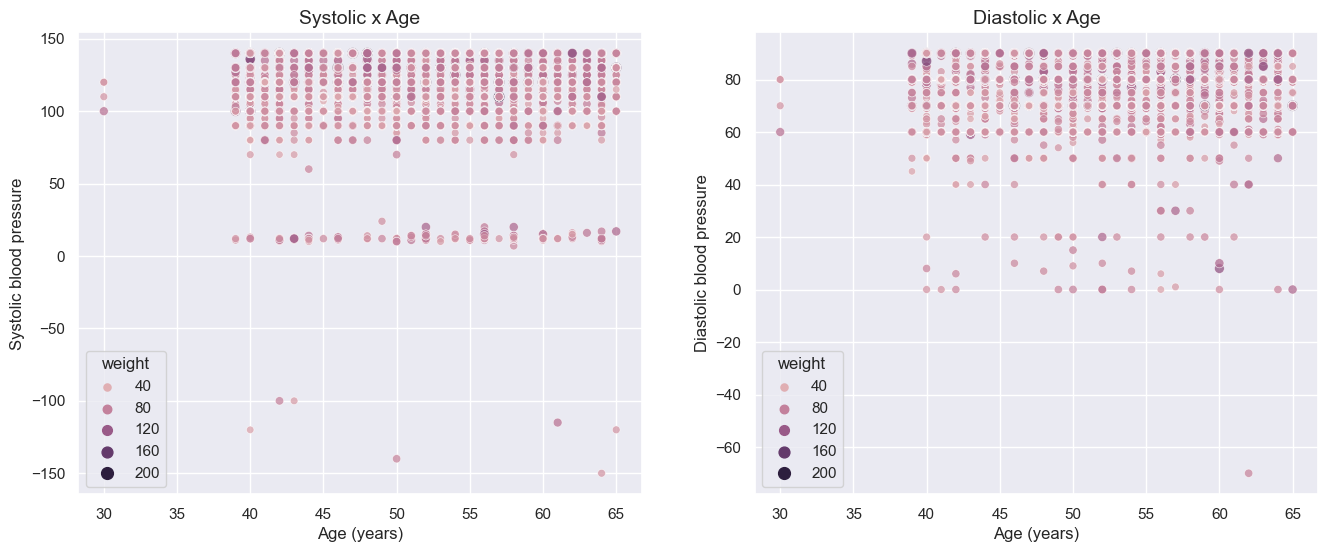

In [24]:
# sets plot size
plt.figure(figsize=(16,6))

# plots scatterplot
plt.subplot(1,2,1)
sns.scatterplot(x='age', y='ap_hi', data=df1, hue='weight', size='weight', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Systolic blood pressure")
plt.title("Systolic x Age", fontsize=14)

plt.subplot(1,2,2)
sns.scatterplot(x='age', y='ap_lo', data=df1, hue='weight', size='weight', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Diastolic blood pressure")
plt.title("Diastolic x Age", fontsize=14)

# displays the plot
plt.show()

May be outliers (based on a search):

- Systolic below 90.
- Diastolic below 60.

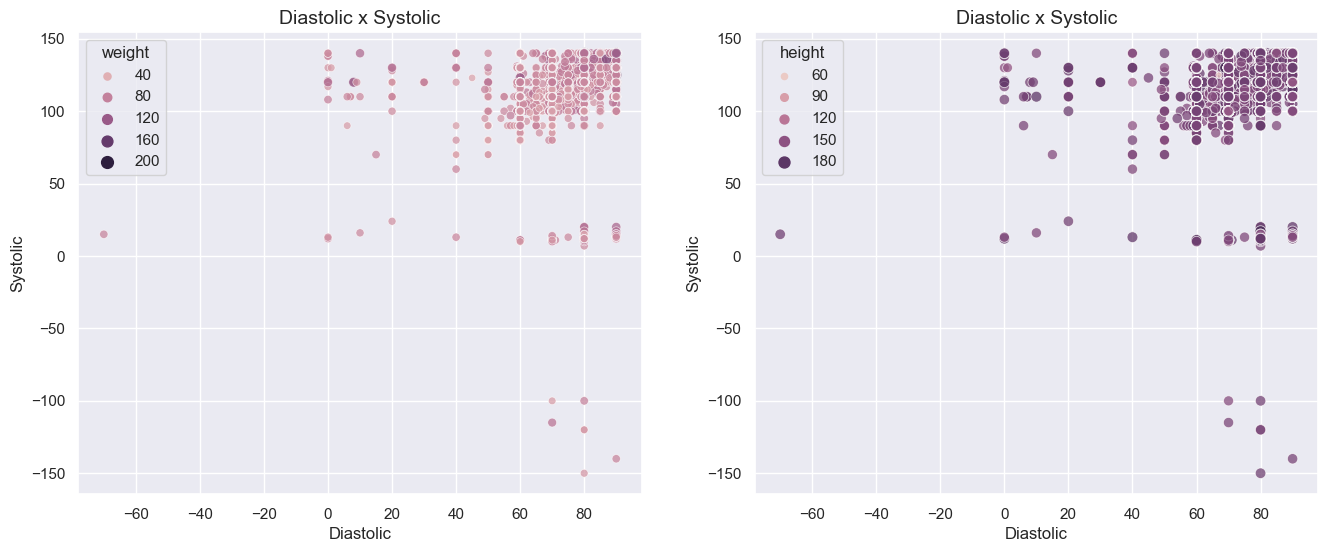

In [25]:
# sets plot size
plt.figure(figsize=(16,6))

plt.subplot(121)
# plots scatterplot
sns.scatterplot(x='ap_lo', y='ap_hi', data=df1, hue='weight', size='weight', alpha=0.75)
plt.xlabel("Diastolic")
plt.ylabel("Systolic")
plt.title("Diastolic x Systolic", fontsize=14)

plt.subplot(122)
# plots scatterplot
sns.scatterplot(x='ap_lo', y='ap_hi', data=df1, hue='height', size='height', alpha=0.75)
plt.xlabel("Diastolic")
plt.ylabel("Systolic")
plt.title("Diastolic x Systolic", fontsize=14)

# displays the plot
plt.show()

Conclusions:

- Diastolic below 50 and systolic below 50 may be outliers. 

### 1.7.3. Removing Outliers

We are going to check the outliers by calculating the Q1, Q3 and IQR.

In [26]:
# calculates Q1, Q3 and IQR for systolic
Q1 = np.quantile(df1['ap_hi'], .25)
Q3 = np.quantile(df1['ap_hi'], .75)
IQR = Q3 - Q1

# calculates the outliers boundaries through statistical relationship
low_outliers = Q1 - 1.5 * IQR
high_outliers = Q3 + 1.5 * IQR

print("Systolic boundaries for outliers")
print(f"Q1 = {Q1}\nQ3 = {Q3}\nIQR = {IQR}\nlow_outliers = {low_outliers}\nhigh_outliers = {high_outliers}")


# calculates Q1, Q3 and IQR fir diastolic
Q1 = np.quantile(df1['ap_lo'], .25)
Q3 = np.quantile(df1['ap_lo'], .75)
IQR = Q3 - Q1

# calculates the outliers boundaries through statistical relationship
low_outliers = Q1 - 1.5 * IQR
high_outliers = Q3 + 1.5 * IQR

print("\nDiastolic boundaries for outliers")
print(f"Q1 = {Q1}\nQ3 = {Q3}\nIQR = {IQR}\nlow_outliers = {low_outliers}\nhigh_outliers = {high_outliers}")

Systolic boundaries for outliers
Q1 = 120.0
Q3 = 130.0
IQR = 10.0
low_outliers = 105.0
high_outliers = 145.0

Diastolic boundaries for outliers
Q1 = 80.0
Q3 = 80.0
IQR = 0.0
low_outliers = 80.0
high_outliers = 80.0


Besides the value above, we chose to consider as outliers the values found from a search:

- Systolic lower than 90 and higher than 210.
- Diastolic lower than 60 and higher than 150.

In [27]:
# check the values that will be considered as outliers
df1[(df1['ap_hi'] >= 210) | (df1['ap_lo'] >= 150) 
           | (df1['ap_hi'] <= 90) | (df1['ap_lo'] <= 60)]

id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
4          4   48       1     156   56.00    100     60            1     1   
9         14   54       1     164   68.00    110     60            1     1   
23        33   64       2     156   45.00    110     60            1     1   
43        58   56       2     159   63.00    120     60            1     1   
50        65   50       1     160   75.00    100     60            1     1   
...      ...  ...     ...     ...     ...    ...    ...          ...   ...   
69912  99861   44       1     155   48.00     90     70            1     1   
69922  99878   42       1     165   62.00    100     60            1     1   
69932  99897   42       2     171   67.00    110     60            1     1   
69937  99908   40       1     160   53.00     90     60            1     1   
69978  99967   52       1     163   78.00     90     60            1     1   

       smoke  alco  active  cardio  
4          0     0       0       0  
9          0     0       0       0  
23         0     0       1       0  
43         0     0       1       1  
50         0     0       0       0  
...      ...   ...     ...     ...  
69912      0     0       1       0  
69922      0     0       1       0  
69932      0     0       1       0  
69937      0     0       1       0  
69978      0     0       1       1  

[3150 rows x 13 columns]

In [28]:
# removes outliers: blood pressure
df1 = df1[~((df1['ap_hi'] >= 210) | (df1['ap_lo'] >= 150) 
           | (df1['ap_hi'] <= 90) | (df1['ap_lo'] <= 60))]

# removes outliers: height
df1 = df1[~df1['height'] <= 120]

# removes outliers: weight
df1 = df1[~(df1['weight'] <= 25)]

df1

id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
0          0   50       2     168   62.00    110     80            1     1   
1          1   55       1     156   85.00    140     90            3     1   
2          2   52       1     165   64.00    130     70            3     1   
5          8   60       1     151   67.00    120     80            2     2   
6          9   61       1     157   93.00    130     80            3     1   
...      ...  ...     ...     ...     ...    ...    ...          ...   ...   
69993  99991   54       1     172   70.00    130     90            1     1   
69995  99993   53       2     168   76.00    120     80            1     1   
69996  99995   62       1     158  126.00    140     90            2     2   
69998  99998   61       1     163   72.00    135     80            1     2   
69999  99999   56       1     170   72.00    120     80            2     1   

       smoke  alco  active  cardio  
0          0     0       1       0  
1          0     0       1       1  
2          0     0       0       1  
5          0     0       0       0  
6          0     0       1       0  
...      ...   ...     ...     ...  
69993      0     0       1       1  
69995      1     0       1       0  
69996      0     0       1       1  
69998      0     0       0       1  
69999      0     0       1       0  

[55319 rows x 13 columns]

### 1.7.4. Visualizations after the cleaning

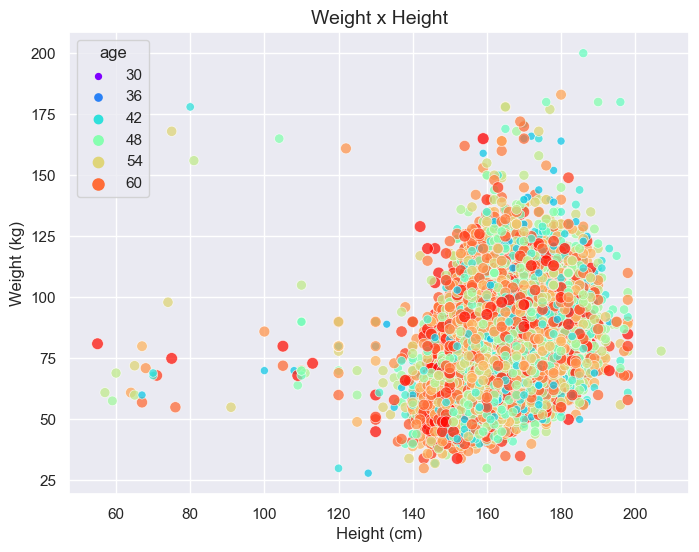

In [29]:
# sets plot size
plt.figure(figsize=(8,6))

# plots scatterplot
sns.scatterplot(x='height', y='weight', data=df1, hue='age', palette='rainbow', size='age', alpha=0.75)
plt.xlabel("Height (cm)")
plt.ylabel("Weight (kg)")
plt.title("Weight x Height", fontsize=14)

# displays the plot
plt.show()

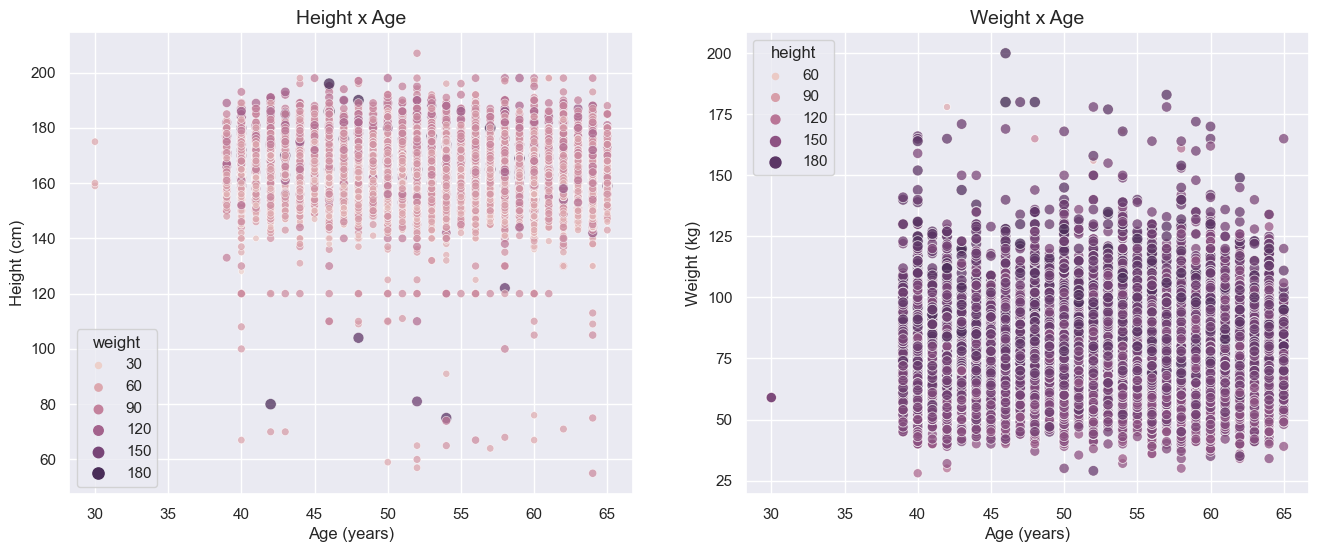

In [30]:
# sets plot size
plt.figure(figsize=(16,6))

# plots scatterplot
plt.subplot(1,2,1)
sns.scatterplot(x='age', y='height', data=df1, hue='weight', size='weight', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Height (cm)")
plt.title("Height x Age", fontsize=14)

# plots scatterplot
plt.subplot(1,2,2)
sns.scatterplot(x='age', y='weight', data=df1, hue='height', size='height', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Weight (kg)")
plt.title("Weight x Age", fontsize=14)

# displays the plot
plt.show()

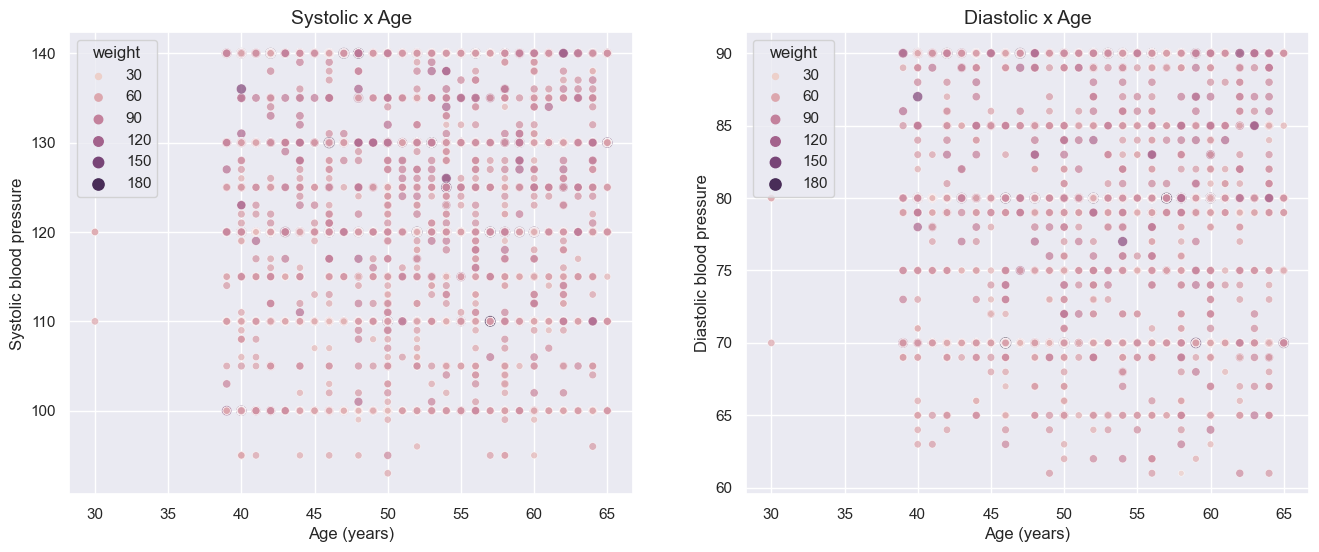

In [31]:
# sets plot size
plt.figure(figsize=(16,6))

# plots scatterplot
plt.subplot(1,2,1)
sns.scatterplot(x='age', y='ap_hi', data=df1, hue='weight', size='weight', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Systolic blood pressure")
plt.title("Systolic x Age", fontsize=14)

plt.subplot(1,2,2)
sns.scatterplot(x='age', y='ap_lo', data=df1, hue='weight', size='weight', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Diastolic blood pressure")
plt.title("Diastolic x Age", fontsize=14)

# displays the plot
plt.show()

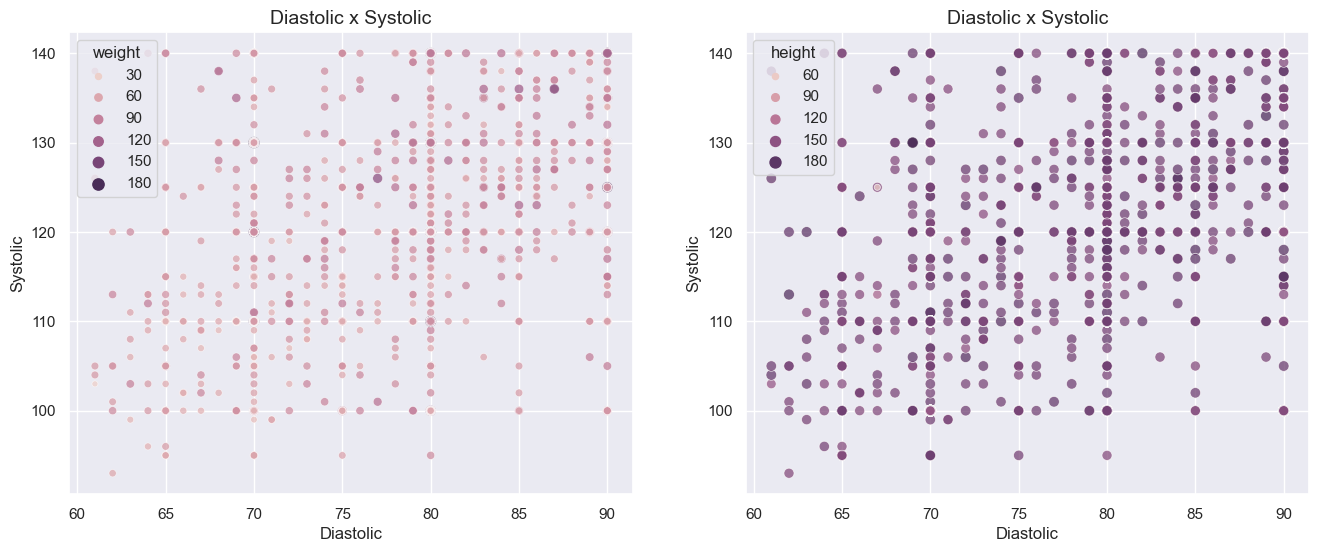

In [32]:
# sets plot size
plt.figure(figsize=(16,6))

plt.subplot(121)
# plots scatterplot
sns.scatterplot(x='ap_lo', y='ap_hi', data=df1, hue='weight', size='weight', alpha=0.75)
plt.xlabel("Diastolic")
plt.ylabel("Systolic")
plt.title("Diastolic x Systolic", fontsize=14)

plt.subplot(122)
# plots scatterplot
sns.scatterplot(x='ap_lo', y='ap_hi', data=df1, hue='height', size='height', alpha=0.75)
plt.xlabel("Diastolic")
plt.ylabel("Systolic")
plt.title("Diastolic x Systolic", fontsize=14)

# displays the plot
plt.show()

# 2. Feature Engineering

In [33]:
df2 = df1.copy()

## 2.1. BMI

BMI means body mass index. We can classify people accordingly to their body mass. 

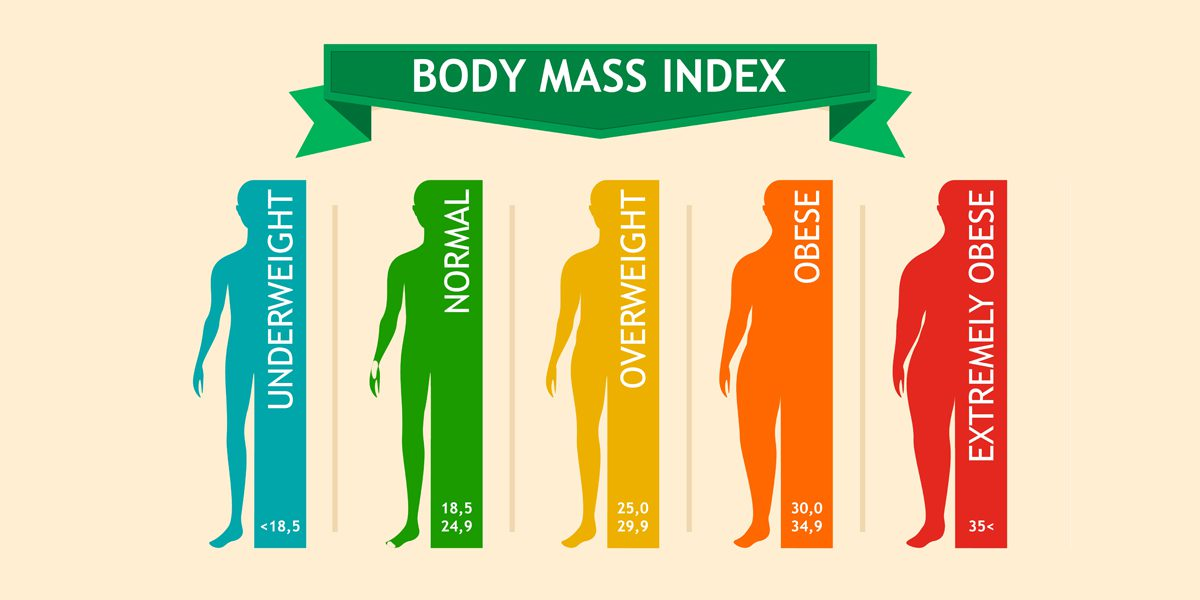

In [34]:
Image("Images/bmi.jpeg")

In [35]:
# calculates the height in squared meters
height_squared_meters = np.multiply(df2['height']/100, df2['height']/100)

# calculates BMI
df2['bmi'] = np.divide(df2['weight'], height_squared_meters)

Now we are going to calculate the average BMI of a person classified as bmi-normal.

In [36]:
round(df2[(df2["bmi"] >= 18.5 ) & (df2["bmi"] <= 24.9)]["bmi"].mean(), 2)

22.95

Now, let's create a column for this difference:

In [37]:
avg_norm_bmi = round(df2[(df2["bmi"] >= 18.5 ) & (df2["bmi"] <= 24.9)]["bmi"].mean(), 2)

df2["bmi_diff"] = df2["bmi"].apply(lambda x: x - avg_norm_bmi)

In [38]:
# calculates the weight status
df2['bmi_class'] = df2['bmi'].apply(lambda x: 'underweight' if x < 18.5 
                                                     else 'normal' if (x >= 18.5) & (x <= 24.9)
                                                     else 'overweight' if (x >= 25) & (x <= 29.9)
                                                     else 'obese' if (x >= 30) & (x <= 34.9)
                                                     else 'extremely_obese')

In [39]:
df2.sample(10)

id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
59003  84220   50       1     153   74.00    120     80            1     1   
40519  57899   55       1     154   67.00    130     90            1     1   
25881  36944   48       2     170   69.00    110     70            1     1   
33422  47748   54       1     158   62.00    120     80            1     1   
60114  85827   49       1     169  102.00    120     80            2     1   
35912  51281   64       2     158   74.00    140     80            3     3   
25393  36242   53       1     156   81.00    130     90            2     1   
29930  42802   54       1     161   92.00    130     90            3     1   
59485  84928   50       1     167   82.00    120     80            1     1   
30294  43326   57       1     160   60.00    130     80            3     3   

       smoke  alco  active  cardio   bmi  bmi_diff        bmi_class  
59003      0     0       1       0 31.61      8.66            obese  
40519      0     0       1       1 28.25      5.30       overweight  
25881      0     0       1       0 23.88      0.93           normal  
33422      0     0       0       0 24.84      1.89           normal  
60114      0     0       1       0 35.71     12.76  extremely_obese  
35912      0     0       1       1 29.64      6.69       overweight  
25393      0     1       1       1 33.28     10.33            obese  
29930      0     0       1       1 35.49     12.54  extremely_obese  
59485      0     0       1       1 29.40      6.45       overweight  
30294      0     0       0       1 23.44      0.49           normal

## 2.2. Blood Pressure

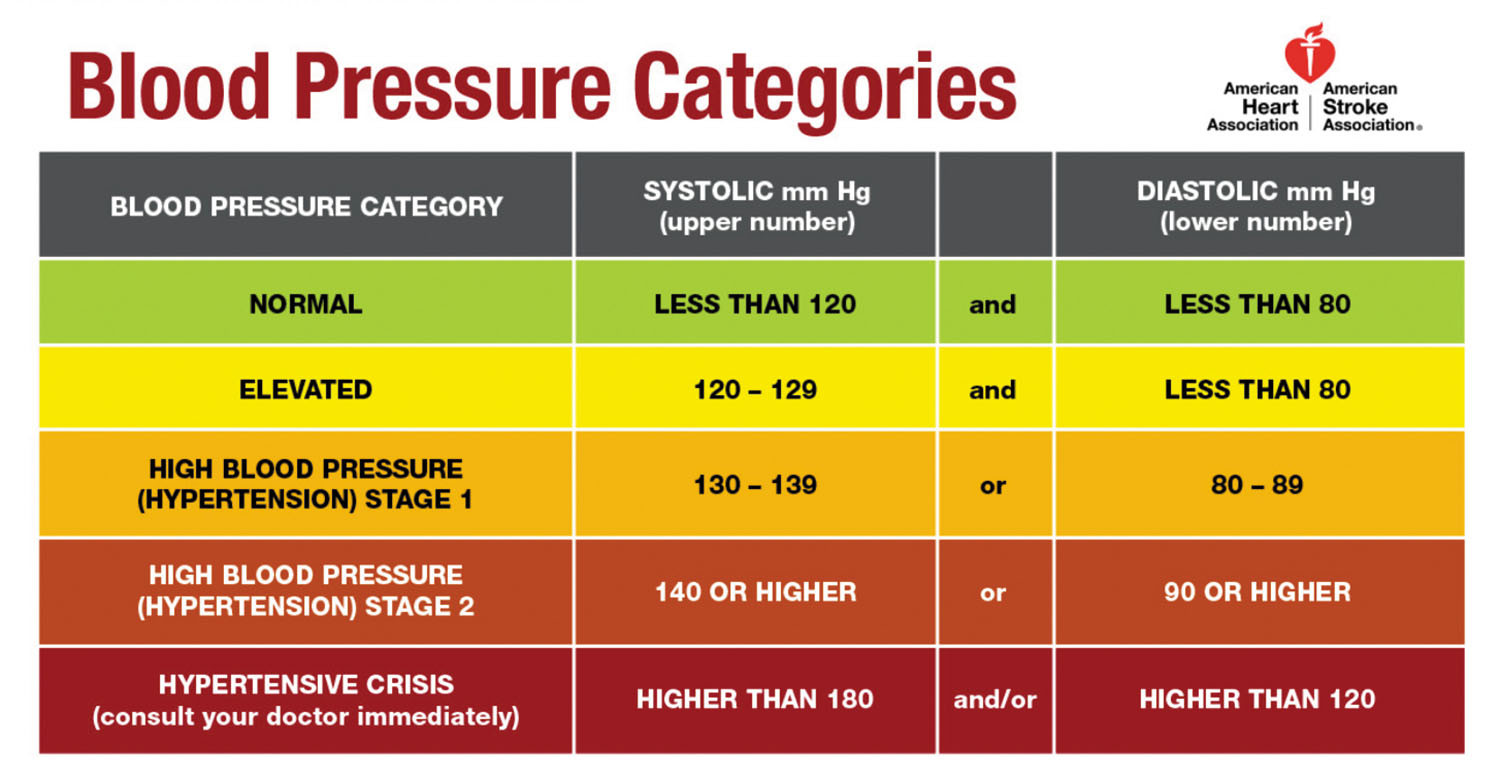

In [41]:
Image("Images/bloodpressure.jpeg")

In [43]:
 # calculates the blood pressures
df2['blood_pressure'] = ['low' if (ap_hi <= 90) & (ap_lo <= 60)
                            else 'normal' if ((ap_hi > 90) & (ap_hi < 120)) & ((ap_lo > 60) & (ap_lo < 80))
                            else 'elevated' if ((ap_hi >= 120) & (ap_hi <= 129)) & (ap_lo < 80)
                            else 'high stage one' if ((ap_hi >= 130) & (ap_hi <= 139)) | ((ap_lo >= 80) & (ap_lo <=89))
                            else 'high stage two' if (ap_hi >= 140) | (ap_lo >= 90)
                            else 'hypertensive crisis'
                            for ap_hi, ap_lo in zip(df2['ap_hi'], df2['ap_lo'])]



In [44]:
df2.head()

id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0   50       2     168   62.00    110     80            1     1      0   
1   1   55       1     156   85.00    140     90            3     1      0   
2   2   52       1     165   64.00    130     70            3     1      0   
5   8   60       1     151   67.00    120     80            2     2      0   
6   9   61       1     157   93.00    130     80            3     1      0   

   alco  active  cardio   bmi  bmi_diff        bmi_class  blood_pressure  
0     0       1       0 21.97     -0.98           normal  high stage one  
1     0       1       1 34.93     11.98  extremely_obese  high stage two  
2     0       0       1 23.51      0.56           normal  high stage one  
5     0       0       0 29.38      6.43       overweight  high stage one  
6     0       1       0 37.73     14.78  extremely_obese  high stage one

# 3. Feature Filtering and Selection

In [45]:
df3 = df2.copy()

We already did this cleaning in the previous section.

# 4. Exploratory Data Analysis 

In [46]:
df4 = df3.copy()

## 4.1 Univariate analysis

### 4.1.1 Target variable

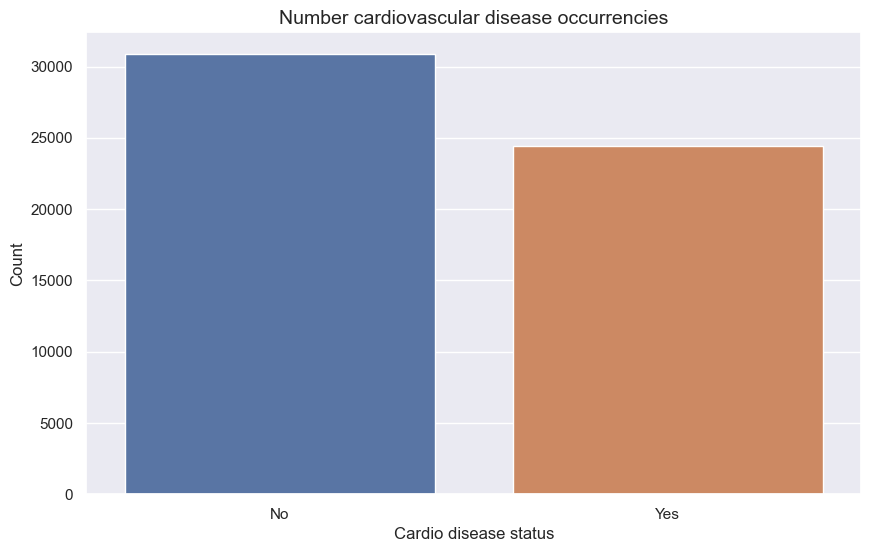

In [50]:
 # sets the plot size
plt.figure(figsize=(10,6))

# counts each class for the target var
_ = sns.countplot(x=df4['cardio'])

# sets plot features
plt.title("Number cardiovascular disease occurrencies", fontsize=14)
plt.xlabel("Cardio disease status")
plt.ylabel("Count")
plt.xticks(ticks=[0,1], labels=['No','Yes'])

# displays the plot
plt.show()

In [51]:
df4["cardio"].value_counts()

0    30860
1    24459
Name: cardio, dtype: int64

In [52]:
df4["cardio"].value_counts(normalize=True)

0   0.56
1   0.44
Name: cardio, dtype: float64

We must balance the classes.

In [59]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes(include=['int64', 'float64']).drop(['id', 'cardio'], axis=1).columns.tolist()

# Categorical
col_cat = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).columns.tolist()

# encoding
df4_dummy = pd.DataFrame(ohe.fit_transform(df4[col_cat]).toarray(), index=df4.index)

# join numerical and categorical
df42 = pd.concat([df4[col_num], df4_dummy], axis=1)
df42.shape

(55319, 22)

In [60]:
# define sampler
oversampling = oversamp.RandomOverSampler(sampling_strategy='all', random_state=32)

# apply sampler
X_over, y_over = oversampling.fit_resample(df42, df4['cardio'])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [61]:
df4['cardio'].value_counts()

0    30860
1    24459
Name: cardio, dtype: int64

In [62]:
y_over.value_counts()

0    30860
1    30860
Name: cardio, dtype: int64

In [63]:
# numerical data
df47 = X_over[col_num]

# categorical data
df48 = X_over.drop(col_num, axis=1)
df49 = pd.DataFrame(ohe.inverse_transform(df48), columns=col_cat, index=df48.index)

# join numerical categorical
df50 = pd.concat([df47, df49], axis=1)
df50['cardio'] = y_over

In [65]:
df50["cardio"].value_counts()

0    30860
1    30860
Name: cardio, dtype: int64

In [66]:
df4 = df50.copy()

### 4.1.2 Numerical variables

In [68]:
# gets the numerical vars
numerical_vars = df4[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'bmi_diff']]

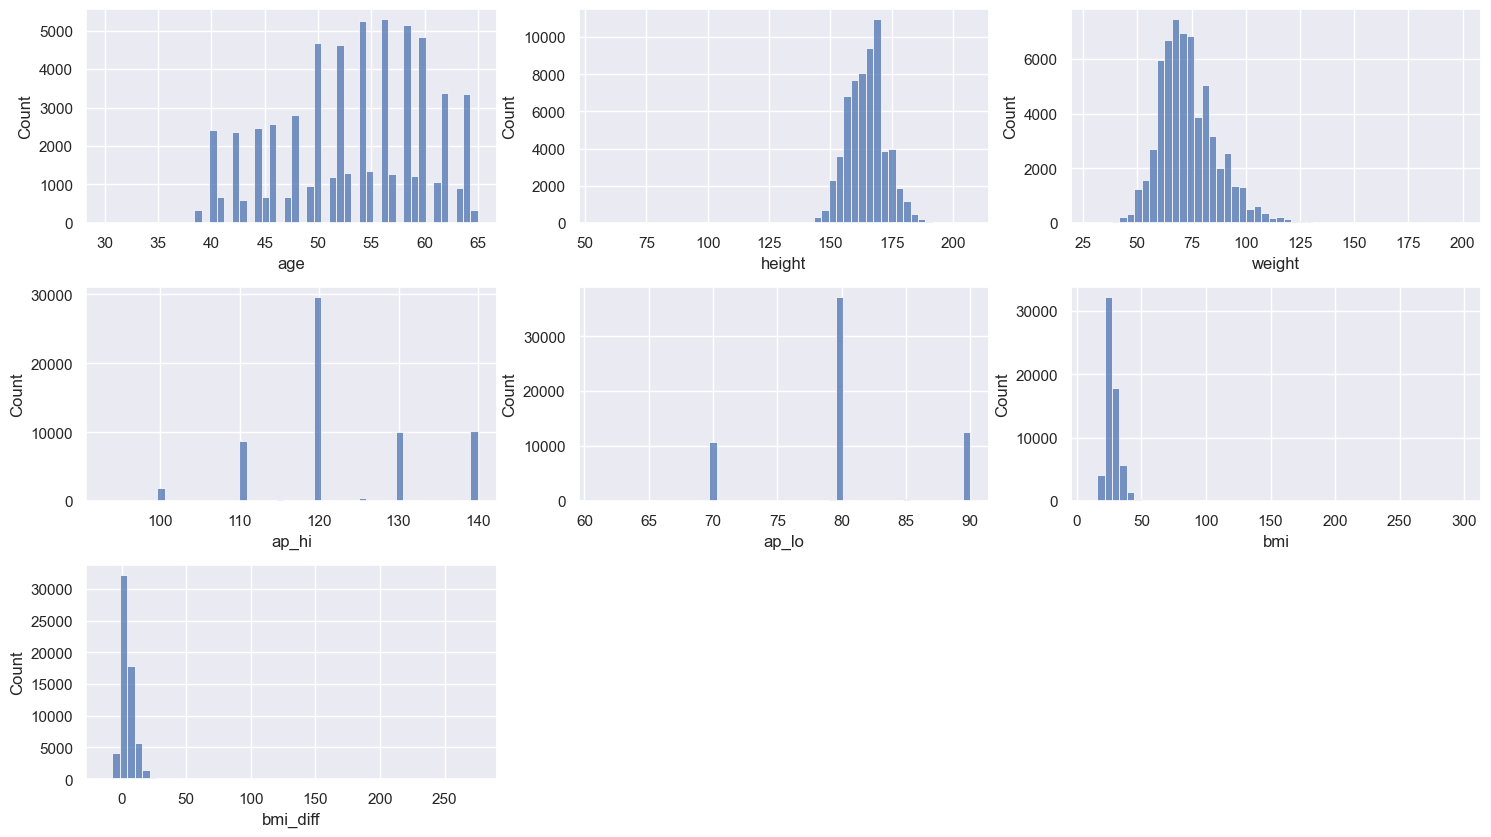

In [69]:
# sets plot size
plt.figure(figsize=(18, 10))

# sets the inital plot position
n = 1

# iterates over the columns to plot
for column in numerical_vars.columns:
    plt.subplot(3, 3, n)
    _ = sns.histplot(x=numerical_vars[column], bins=50)
    n += 1

# adjusts vertical space between plots
plt.subplots_adjust(hspace=0.3)    
    
# display the plot
plt.show() 

Conclusions:
- Majority has ages between 50 and 60 years old.
- Majority is around 170 cm of height.
- Majority weights around 70 kg.
- Majority has blood pressure of 120 for diastolic and 80 for systolic (elevated to high stage 1 blood pressure).

### 4.1.3 Categorical variables

We are considering the following variables as categorical:

In [76]:
# gets the categorical vars
categorical_vars = df4[['gender','cholesterol','gluc','smoke','alco','active', 'blood_pressure']]

In [77]:
categorical_vars.head(3)

gender  cholesterol  gluc  smoke  alco  active  blood_pressure
0       2            1     1      0     0       1  high stage one
1       1            3     1      0     0       1  high stage two
2       1            3     1      0     0       0  high stage one

In [78]:
df4[["gender", "height"]].groupby("gender").mean()

height
gender        
1       161.61
2       169.91

In [79]:
# sets string categories for gender
categorical_vars['gender'] = categorical_vars['gender'].apply(lambda x: 'F' if x == 1 else 'M')

# converts gender to categorical dtype
categorical_vars['gender'] = categorical_vars['gender'].astype('category')

# sets string categories for glucose
categorical_vars['gluc'] = categorical_vars['gluc'].apply(lambda x: 'normal' if x == 1 
                                                                else 'above normal' if x == 2 
                                                                else 'well above normal')
# converts glucose to categorical dtype
categorical_vars['gluc'] = categorical_vars['gluc'].astype('category')

# sets string categories for cholesterol
categorical_vars['cholesterol'] = categorical_vars['cholesterol'].apply(lambda x: 'normal' if x == 1 
                                                                        else 'above normal' if x == 2 
                                                                        else 'well above normal')

# converts cholesterol to categorical dtype
categorical_vars['cholesterol'] = categorical_vars['cholesterol'].astype('category')

# sets string categories for smoke
categorical_vars['smoke'] = categorical_vars['smoke'].apply(lambda x: 'yes' if x == 1 else 'no')

# converts smoke to categorical dtype
categorical_vars['smoke'] = categorical_vars['smoke'].astype('category')

# sets string categories for alcohol intake
categorical_vars['alco'] = categorical_vars['alco'].apply(lambda x: 'yes' if x == 1 else 'no')

# converts alcohol intake to categorical dtype
categorical_vars['alco'] = categorical_vars['alco'].astype('category')

# sets string categories for active
categorical_vars['active'] = categorical_vars['active'].apply(lambda x: 'yes' if x == 1 else 'no')

# converts active to categorical dtype
categorical_vars['active'] = categorical_vars['active'].astype('category')

/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_18665/2735071776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_vars['gender'] = categorical_vars['gender'].apply(lambda x: 'F' if x == 1 else 'M')
/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_18665/2735071776.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_vars['gender'] = categorical_vars['gender'].astype('category')
/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_18665/2735071776.py:8: Set

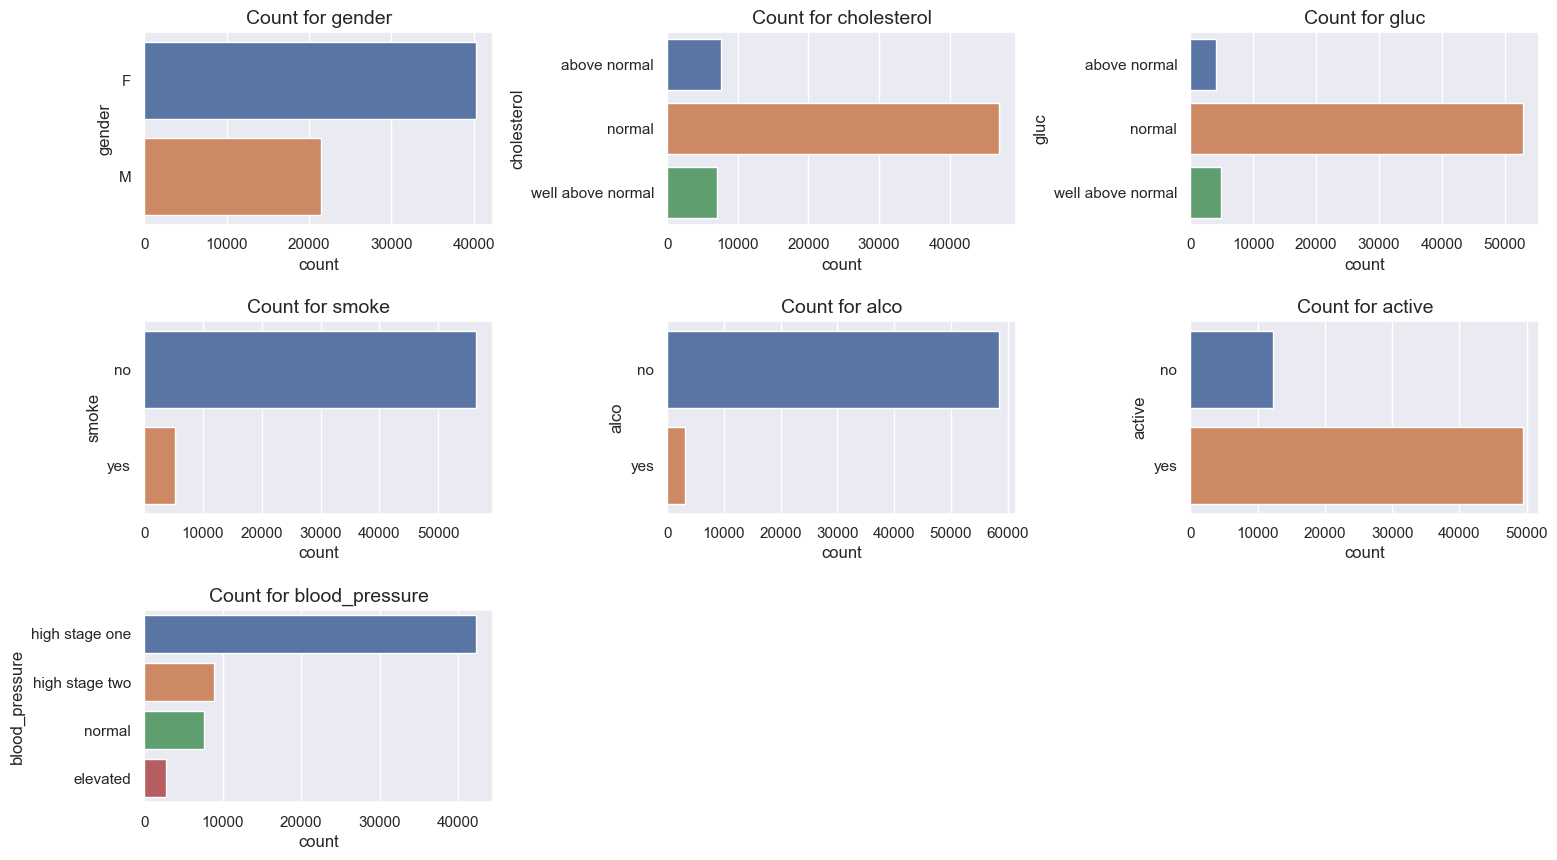

In [80]:
# sets plot size
plt.figure(figsize=(18, 10))

# sets the inital plot position
n = 1

# iterates over the columns to plot
for column in categorical_vars.columns:
    plt.subplot(3, 3, n)
    _ = sns.countplot(y=categorical_vars[column])
    plt.title("Count for " + column, fontsize=14)
    n += 1

# adjust height and wdith reserved for space between subplots  
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)

# display the plot
plt.show()

Conclusions:

- Majority is women.
- Majority has normal cholesterol.
- Majority has normal glucose.
- Majority does not smoke.
- Majority does not drink alcohol. 
- Majority is physically active.
- Majority is at stage one for high blood pressure.

## 4.2. Bivariate analysis (hypothesys test)

- H1. There are less cases of heart diseases among young people (up to 30s).
 
- H2. The cases of heart diseases does not significantly depend on the height.
 
- H3. The higher the weight, the higher is the cases of heart diseases.
 
- H4. The cases of heart diseases does not significantly depend on the gender.
 
- H5. There are more cases of heart diseases for people presenting well above normal levels of cholesterol.
 
- H6. There are more cases of heart diseases for people presenting well above normal levels of glucose.
 
- H7. The are more cases of heart diseases for people who smokes than for people who does not.
 
- H8. The are more cases of heart diseases for people who intakes alcohol than for people who does not.
 
- H9. The are more cases of heart diseases for people who does not do any physical activity than for people who does.
 
- H10. How are the cases of heart diseases distributed among systolic blood pressures?
 
- H11. How are the cases of heart diseases distributed among diastolic blood pressures?

### H1. There are less cases of heart diseases among young people (up to 30s). 

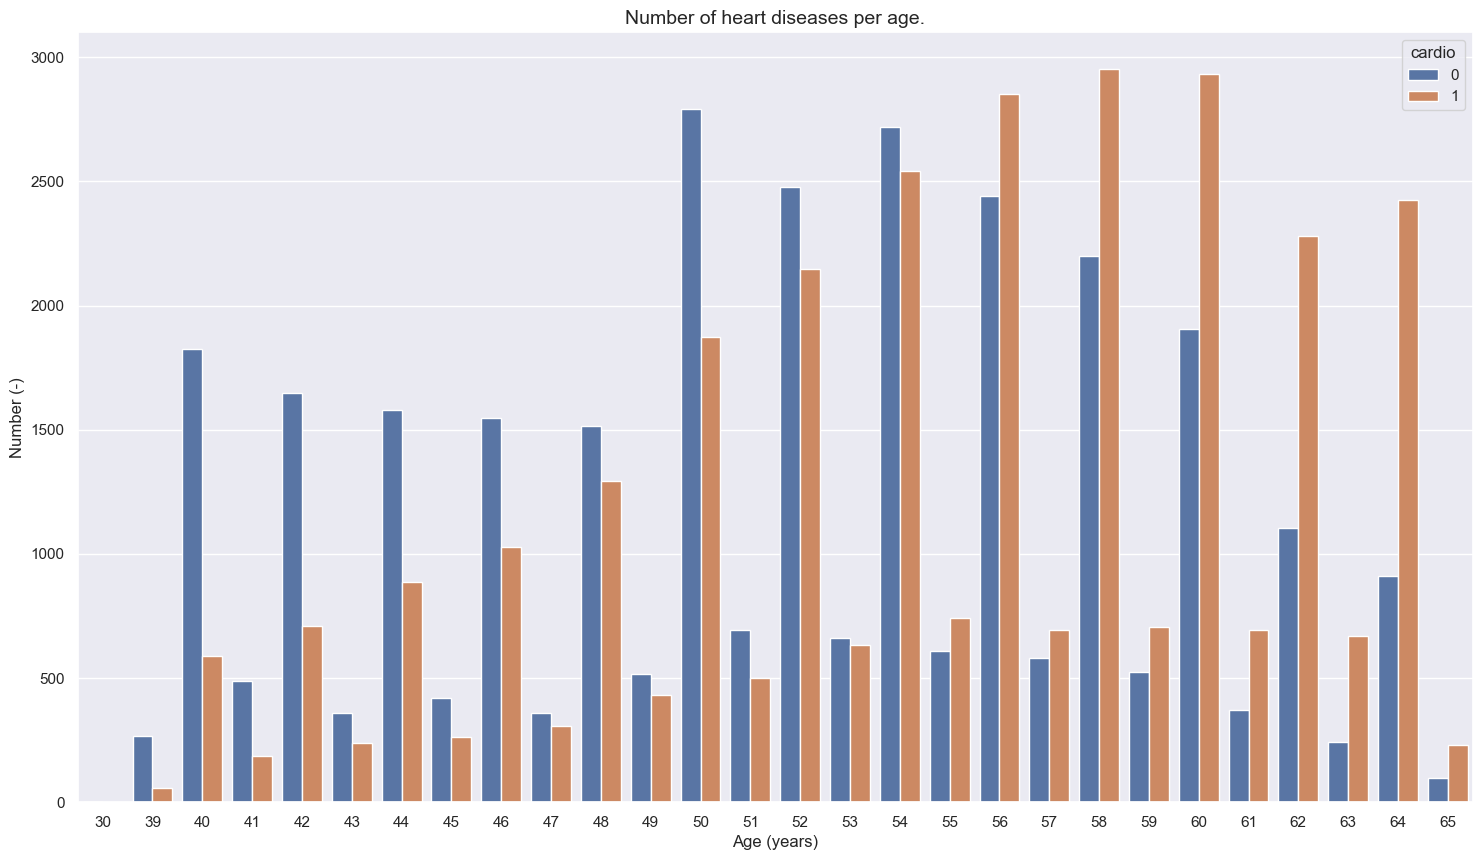

In [84]:
# sets plot size
plt.figure(figsize=(18,10))

# plots countplot
_ = sns.countplot(x='age', hue='cardio', data=df4)

# sets plot features
plt.title("Number of heart diseases per age.", fontsize=14)
plt.xlabel("Age (years)")
plt.ylabel("Number (-)")

# display plot
plt.show()

**True**

- We have higher numbers of heart disease for higher ages (volume: bar height).
- Furthermore, people who are older are more prone to have heart disease (propensity: cardio 1 bar higher than cardio 0). 
- People are more prone to have heart disease after 54 years old.
- There are no heart disease cases under 30.

### H2. The cases of heart diseases does not significantly depend on the height. 

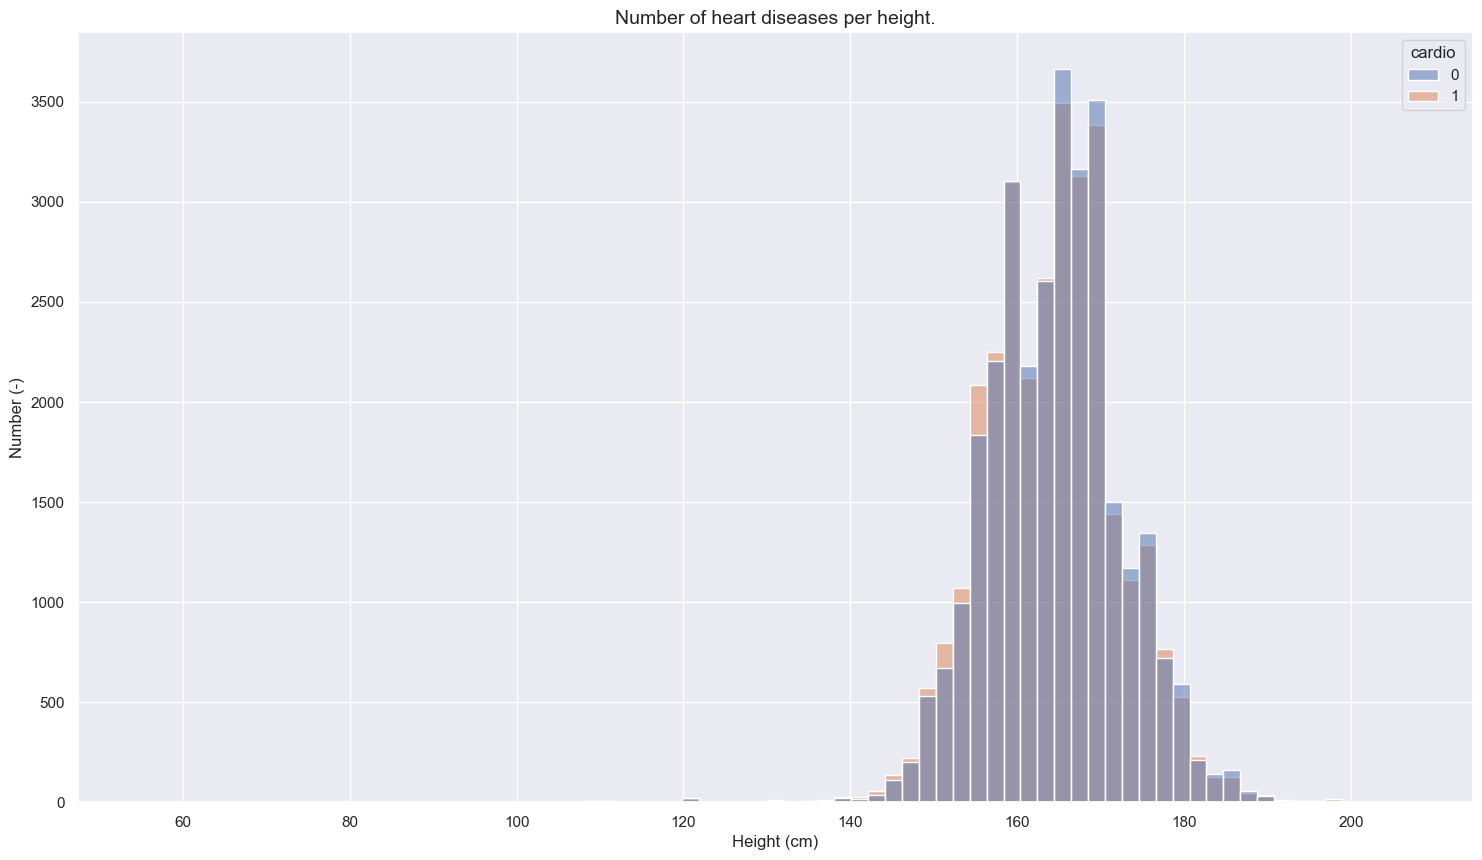

In [86]:
 # sets plot size
plt.figure(figsize=(18,10))

# plots countplot
_ = sns.histplot(x='height', hue='cardio', data=df4, bins=75)

# sets plot features
plt.title("Number of heart diseases per height.", fontsize=14)
plt.xlabel("Height (cm)")
plt.ylabel("Number (-)")

# display plot
plt.show()

**False**

- Smallers people are more prone to have heart diseases.

### H3. The higher the weight, the higher is the cases of heart diseases.

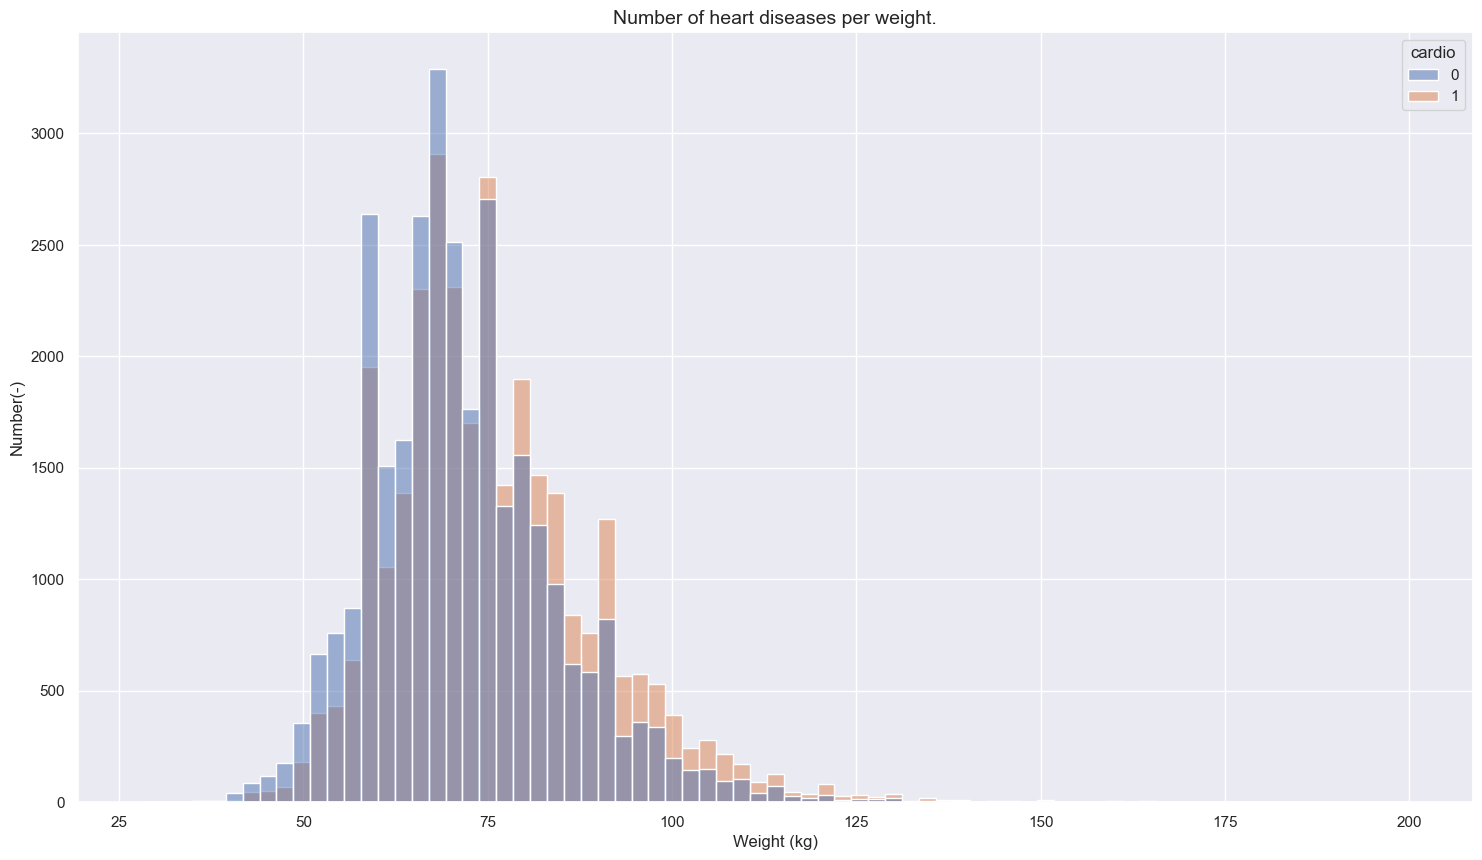

In [87]:
# sets plot size
plt.figure(figsize=(18,10))

# plots countplot
_ = sns.histplot(x='weight', hue='cardio', data=df4, bins=75)

# sets plot features
plt.title("Number of heart diseases per weight.", fontsize=14)
plt.xlabel("Weight (kg)")
plt.ylabel("Number(-)")

# display plot
plt.show()

**True**

- They are less number of occurrencies with higher weights (bar level).
- Yet, people with higher weights are more prone to have heart diseases (1 > 0).

### H4. The cases of heart diseases does not significantly depend on the gender. 

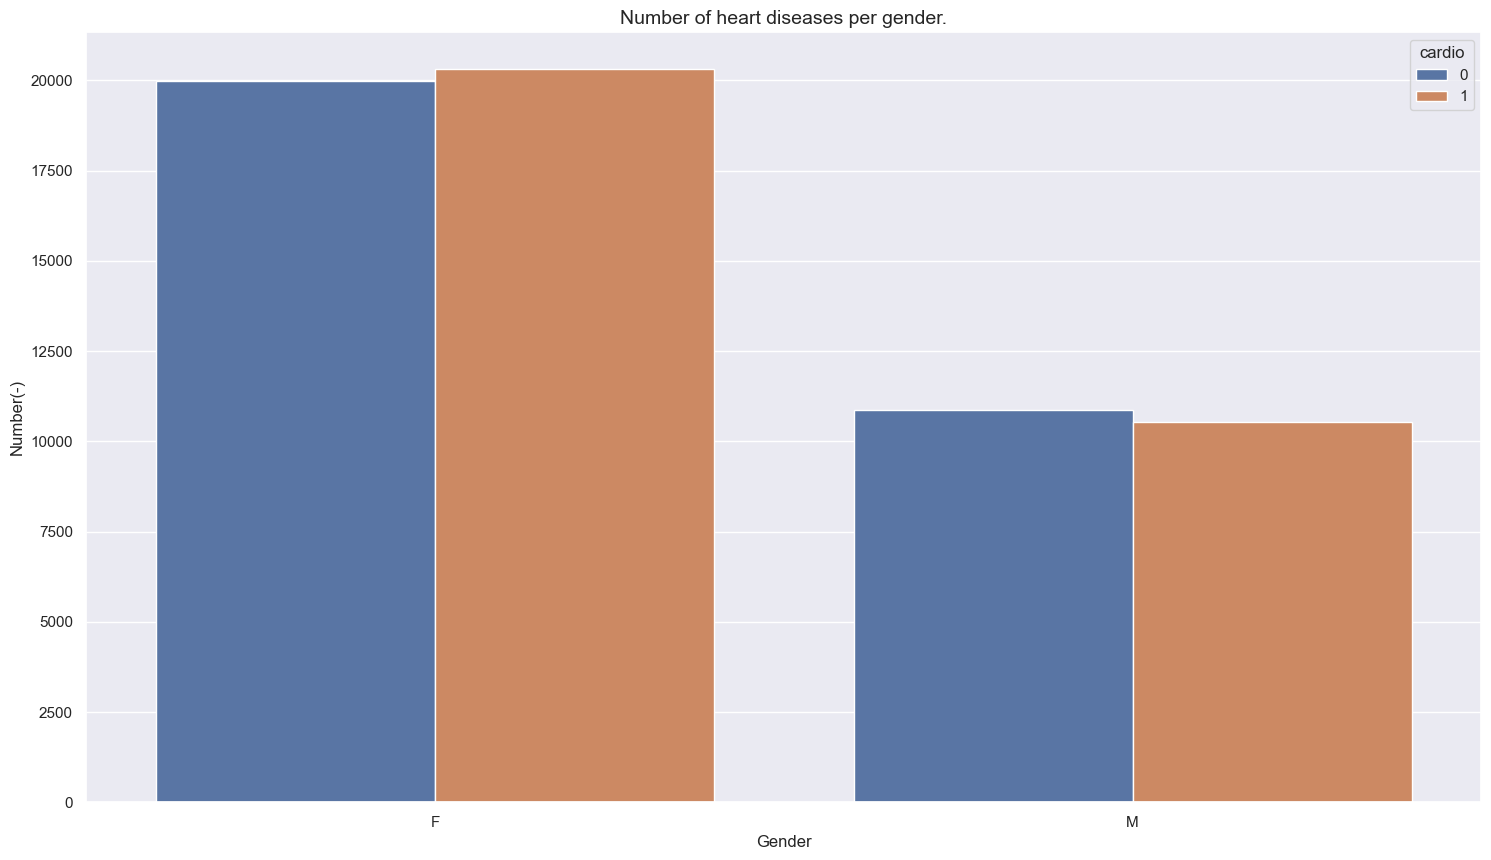

In [90]:
 # sets plot size
plt.figure(figsize=(18,10))

# plots countplot
_ = sns.countplot(x='gender', hue='cardio', data=df4)

# sets plot features
plt.title("Number of heart diseases per gender.", fontsize=14)
plt.xlabel("Gender")
plt.ylabel("Number(-)")
plt.xticks(np.arange(2), ["F", "M"])

# display plot
plt.show()

**False**

- We have higher volume of female with heart disease (bar level). 
- Additionally, female people are more prone to have heart disease (bar differences for cardio). 

### H5. There are more cases of heart diseases for people presenting well above normal levels of cholesterol.

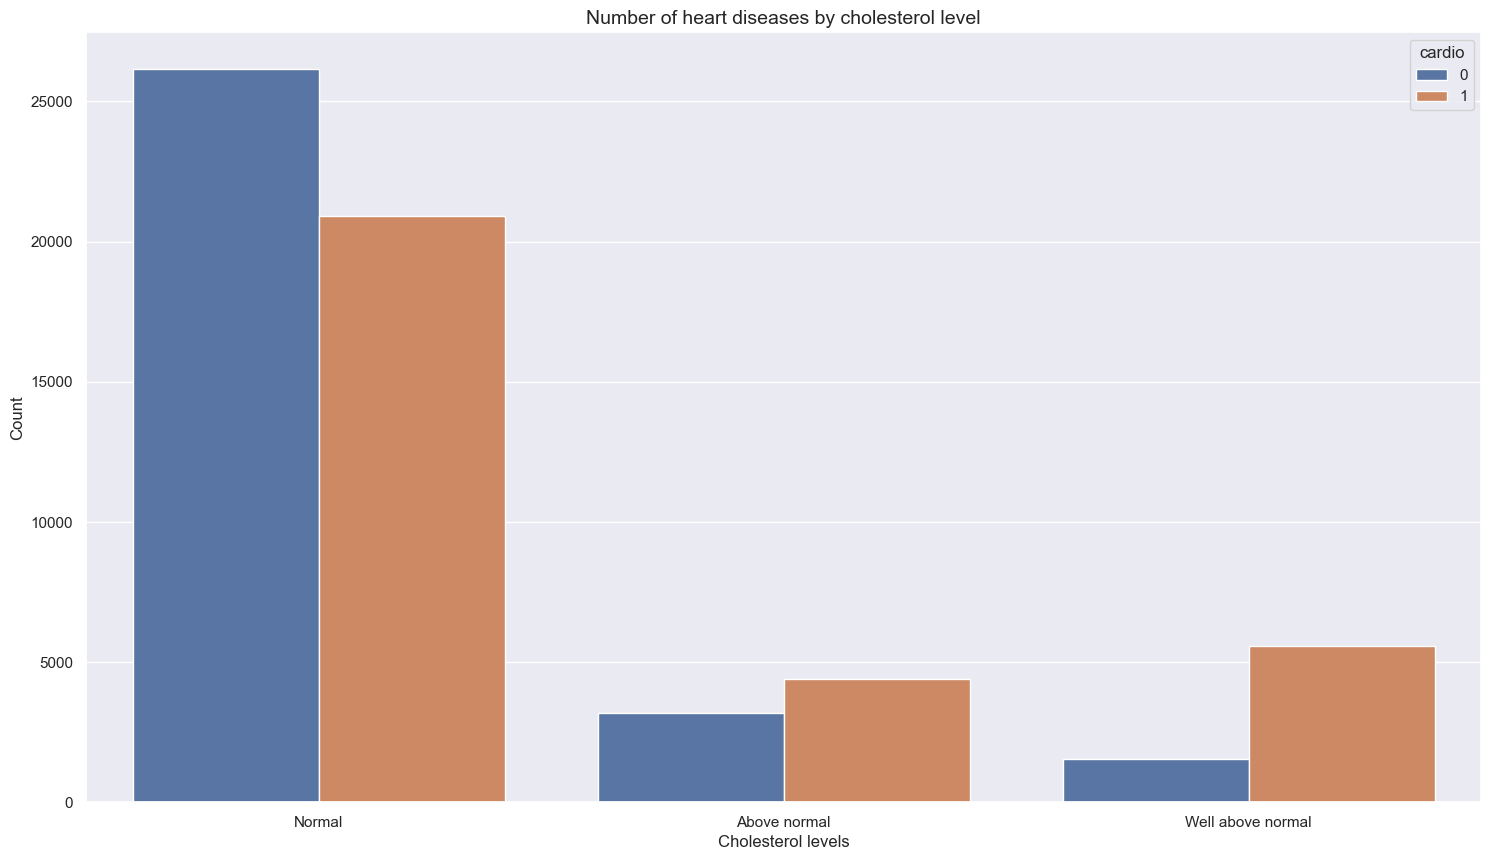

In [92]:
 # sets plot size
plt.figure(figsize=(18,10))

# plots countplot
_ = sns.countplot(x='cholesterol', hue='cardio', data=df4)

# sets plot features
plt.title("Number of heart diseases by cholesterol level", fontsize=14)
plt.xlabel("Cholesterol levels")
plt.ylabel("Count")
plt.xticks(ticks=[0,1,2], labels=['Normal','Above normal','Well above normal'])

# display plot
plt.show()

**True**

- Although we have more occurrencies of normal people with cholesterol (bar level);
- People with above normal levels are more prone to have heart disease. 

### H6. There are more cases of heart diseases for people presenting well above normal levels of glucose.

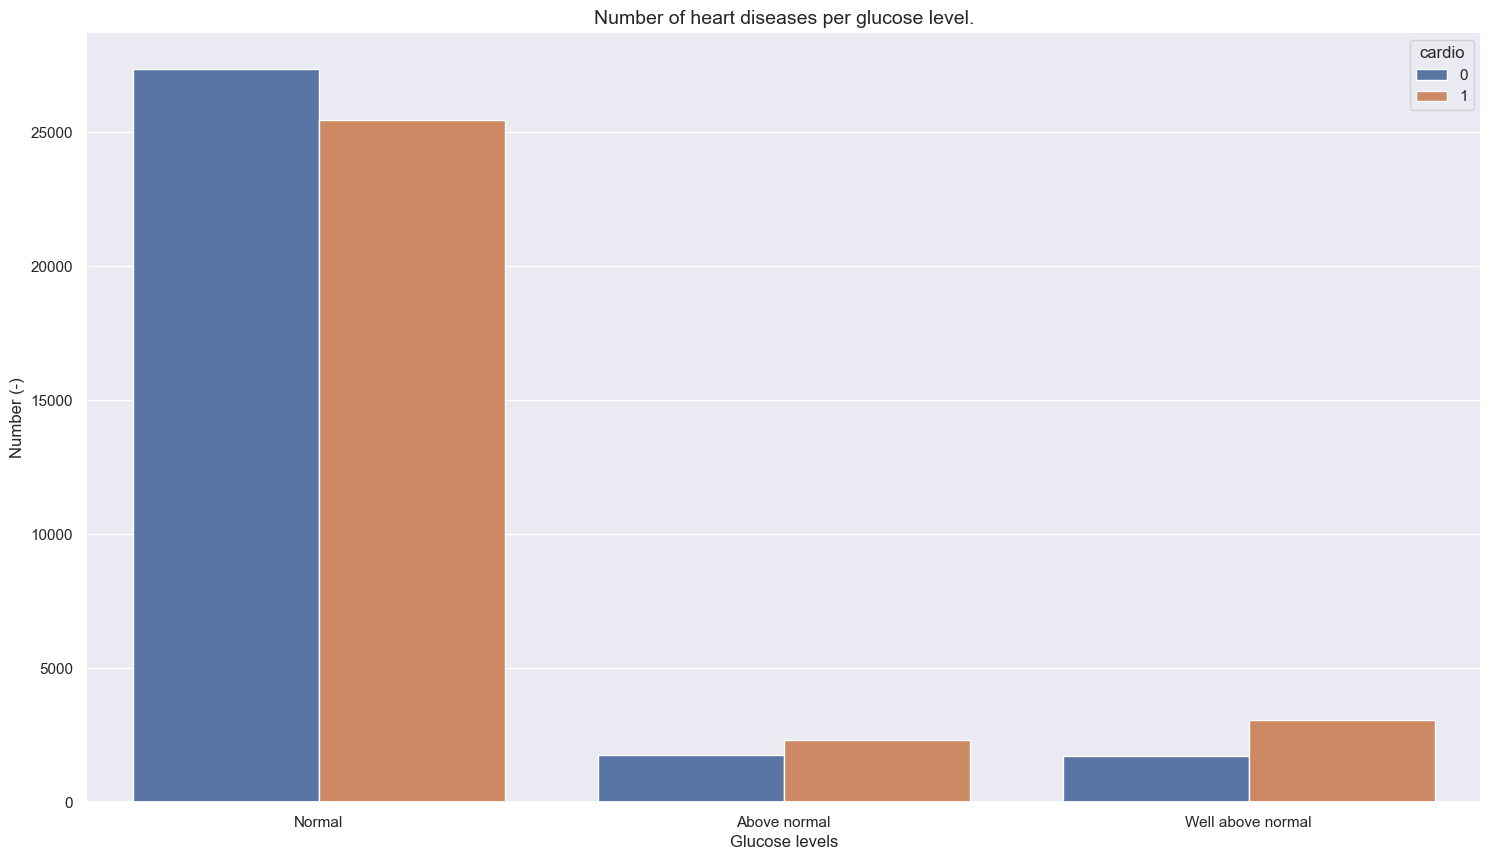

In [93]:
# sets plot size
plt.figure(figsize=(18,10))

# plots countplot
_ = sns.countplot(x='gluc', hue='cardio', data=df4)

# sets plot features
plt.title("Number of heart diseases per glucose level.", fontsize=14)
plt.xlabel("Glucose levels")
plt.ylabel("Number (-)")
plt.xticks(ticks=[0,1,2], labels=['Normal','Above normal','Well above normal'])

# display plot
plt.show()

**True**

- There are much more cases for cardio disease for people with normal level of glucose.
- However, people with glucose levels higher above normal are more prone to have heart disease.

### H7. The are more cases of heart diseases for people who smokes than for people who do not.

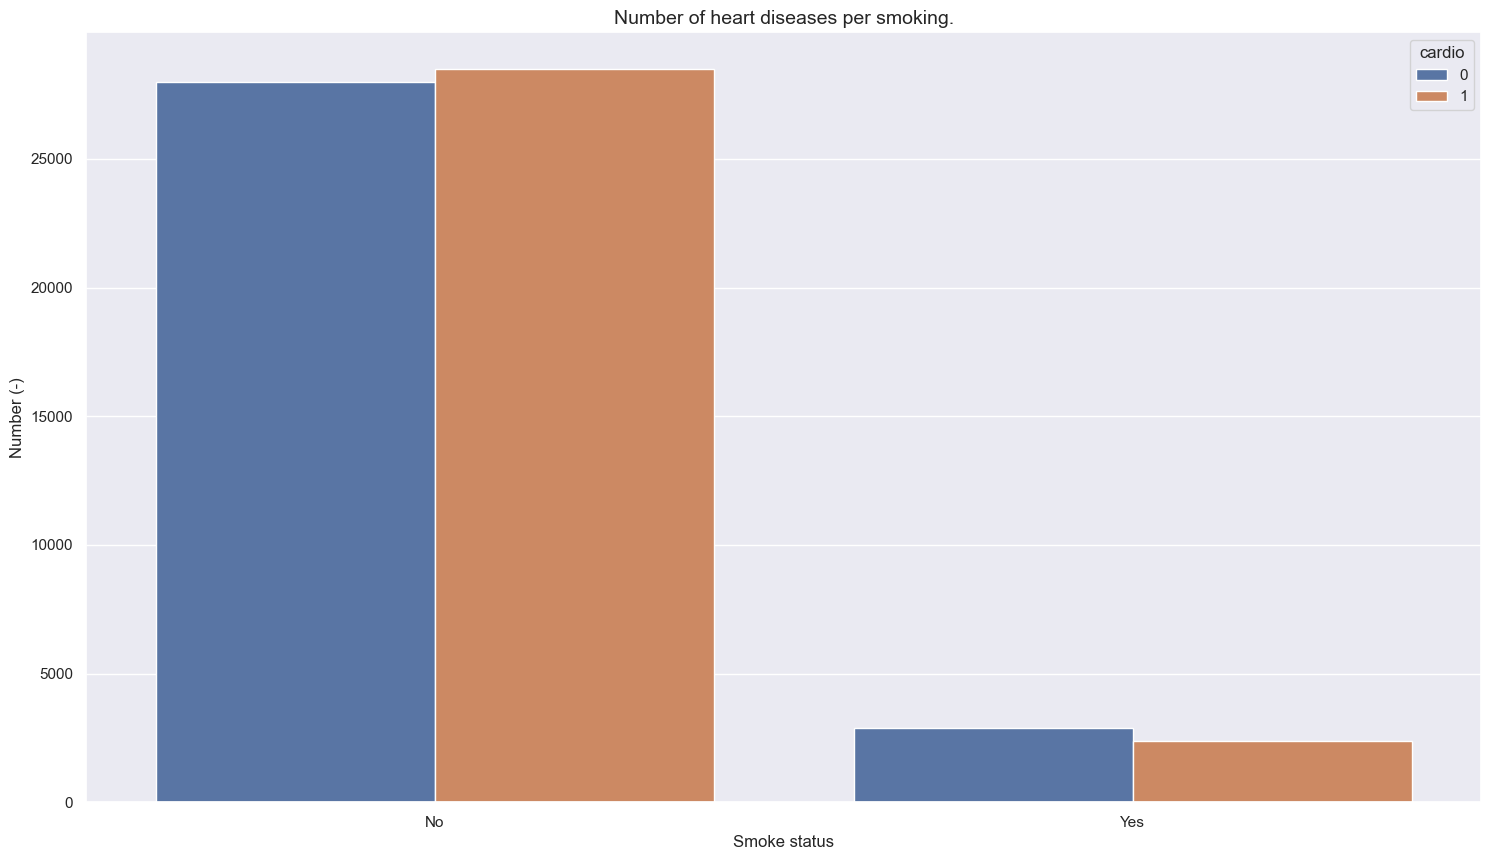

In [94]:
# sets plot size
plt.figure(figsize=(18,10))

# plots countplot
_ = sns.countplot(x='smoke', hue='cardio', data=df4)

# sets plot features
plt.title("Number of heart diseases per smoking.", fontsize=14)
plt.xlabel("Smoke status")
plt.ylabel("Number (-)")
plt.xticks(ticks=[0,1], labels=['No', 'Yes'])

# display plot
plt.show()

**False**

- There are much more cases for people who do not smoke;
- Additionally, people who do not smoke are more prone to have heart disease.

### H8. The are more cases of heart diseases for people who intakes alcohol than for people who do not.

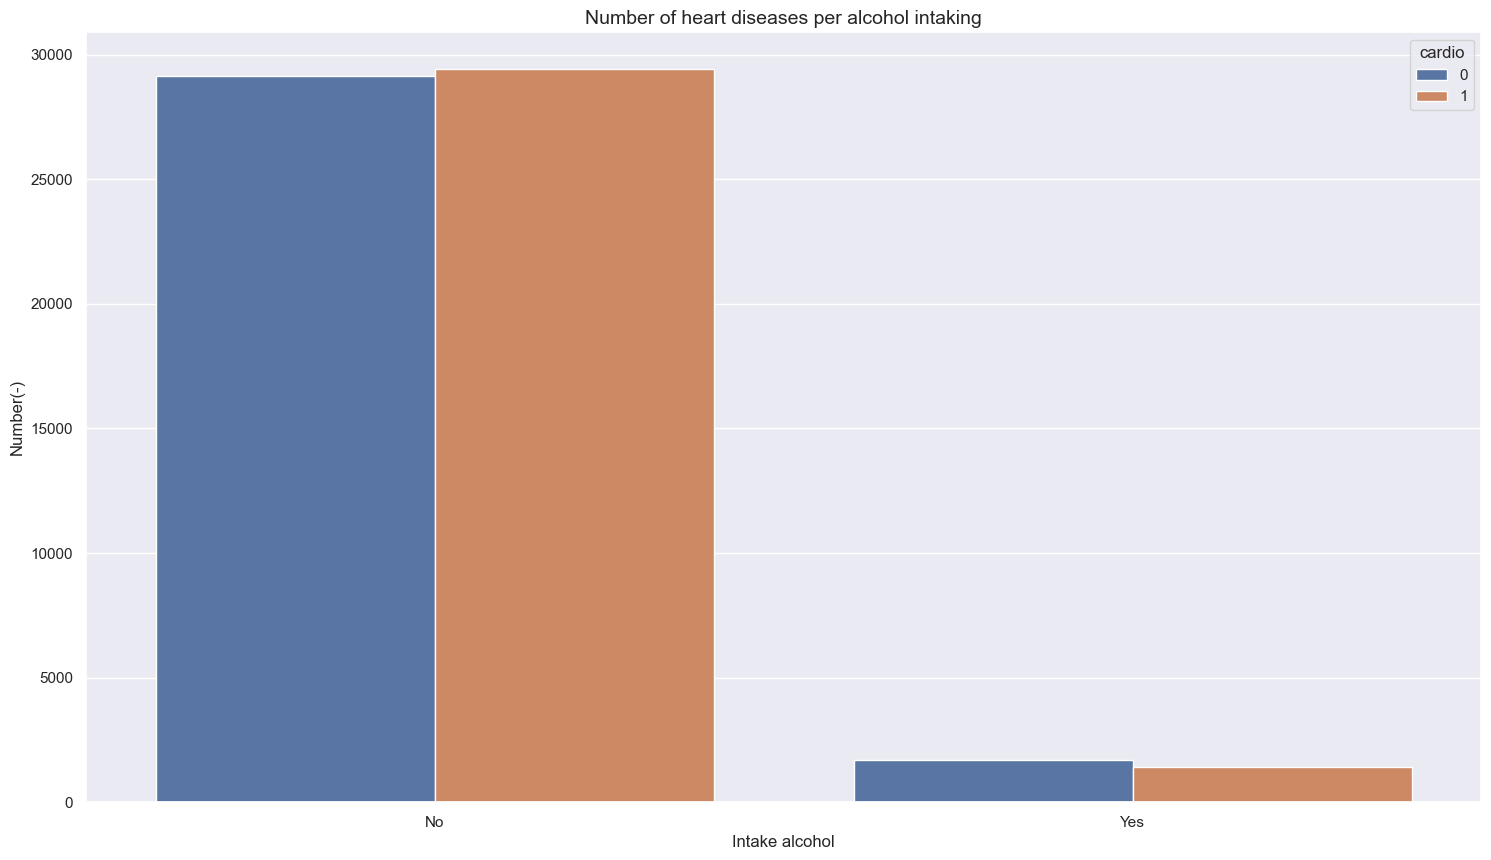

In [99]:
# sets plot size
plt.figure(figsize=(18,10))

# plots countplot
_ = sns.countplot(x='alco', hue='cardio', data=df4)

# sets plot features
plt.title("Number of heart diseases per alcohol intaking", fontsize=14)
plt.xlabel("Intake alcohol")
plt.ylabel("Number(-)")
plt.xticks(ticks=[0,1], labels=['No', 'Yes'])

# display plot
plt.show()

**False**

- There are more cases for people who do not intake alcohol;
- Additionally, they are more prone to have heart disease.

###  H9. The are more cases of heart diseases for people who do not have physical activity.

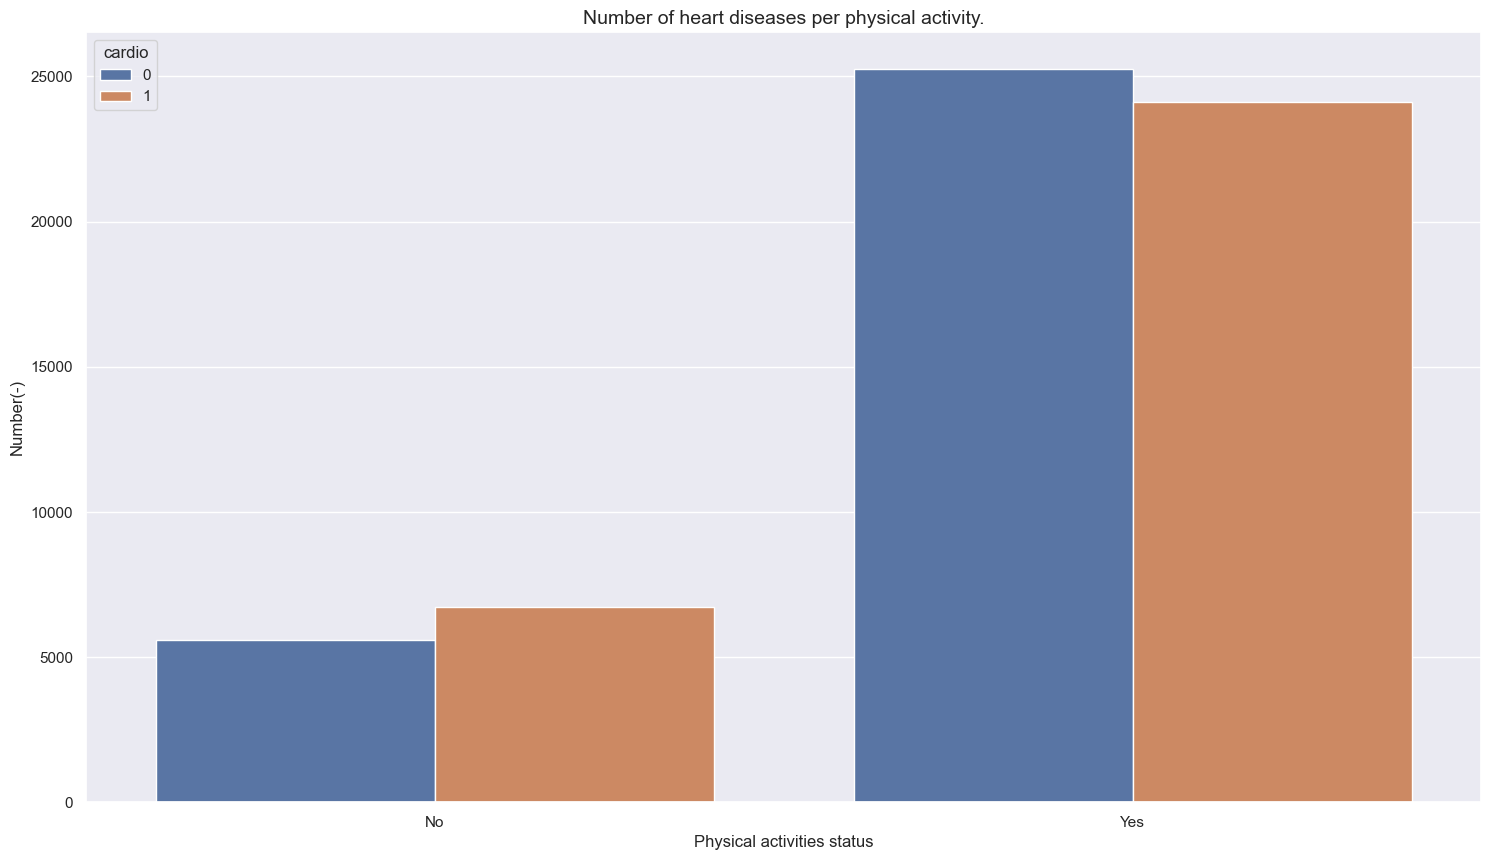

In [98]:
 # sets plot size
plt.figure(figsize=(18,10))

# plots countplot
_ = sns.countplot(x='active', hue='cardio', data=df4)

# sets plot features
plt.title("Number of heart diseases per physical activity.", fontsize=14)
plt.xlabel("Physical activities status")
plt.ylabel("Number(-)")
plt.xticks(ticks=[0,1], labels=['No', 'Yes'])

# display plot
plt.show()

**True**

- There are more cases for people who do physical activity;
- However, people who do not are more prone to have heart disease.

### H10. How are the cases of heart diseases distributed among systolic blood pressures?

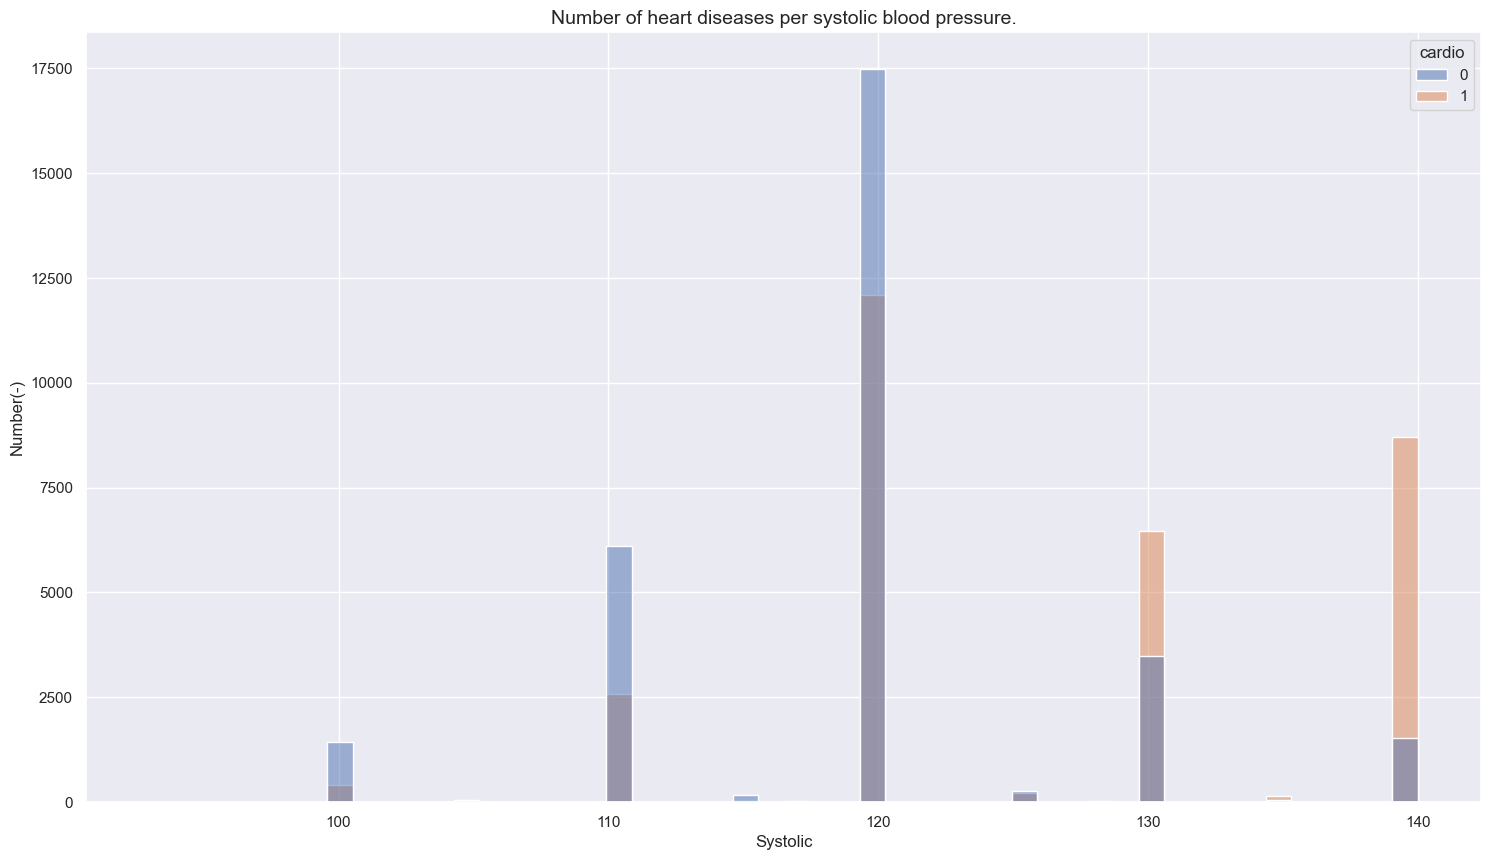

In [100]:
 # sets plot size
plt.figure(figsize=(18,10))

# plots countplot
_ = sns.histplot(x='ap_hi', hue='cardio', data=df4, bins=50)

# sets plot features
plt.title("Number of heart diseases per systolic blood pressure.", fontsize=14)
plt.xlabel("Systolic")
plt.ylabel("Number(-)")

# display plot
plt.show()

- There are more cases for people with systolic equals to 120;
- However, people with systolic higher than 130 are more prone to have heart disease.

### H11. How are the cases of heart diseases distributed among diastolic blood pressures?

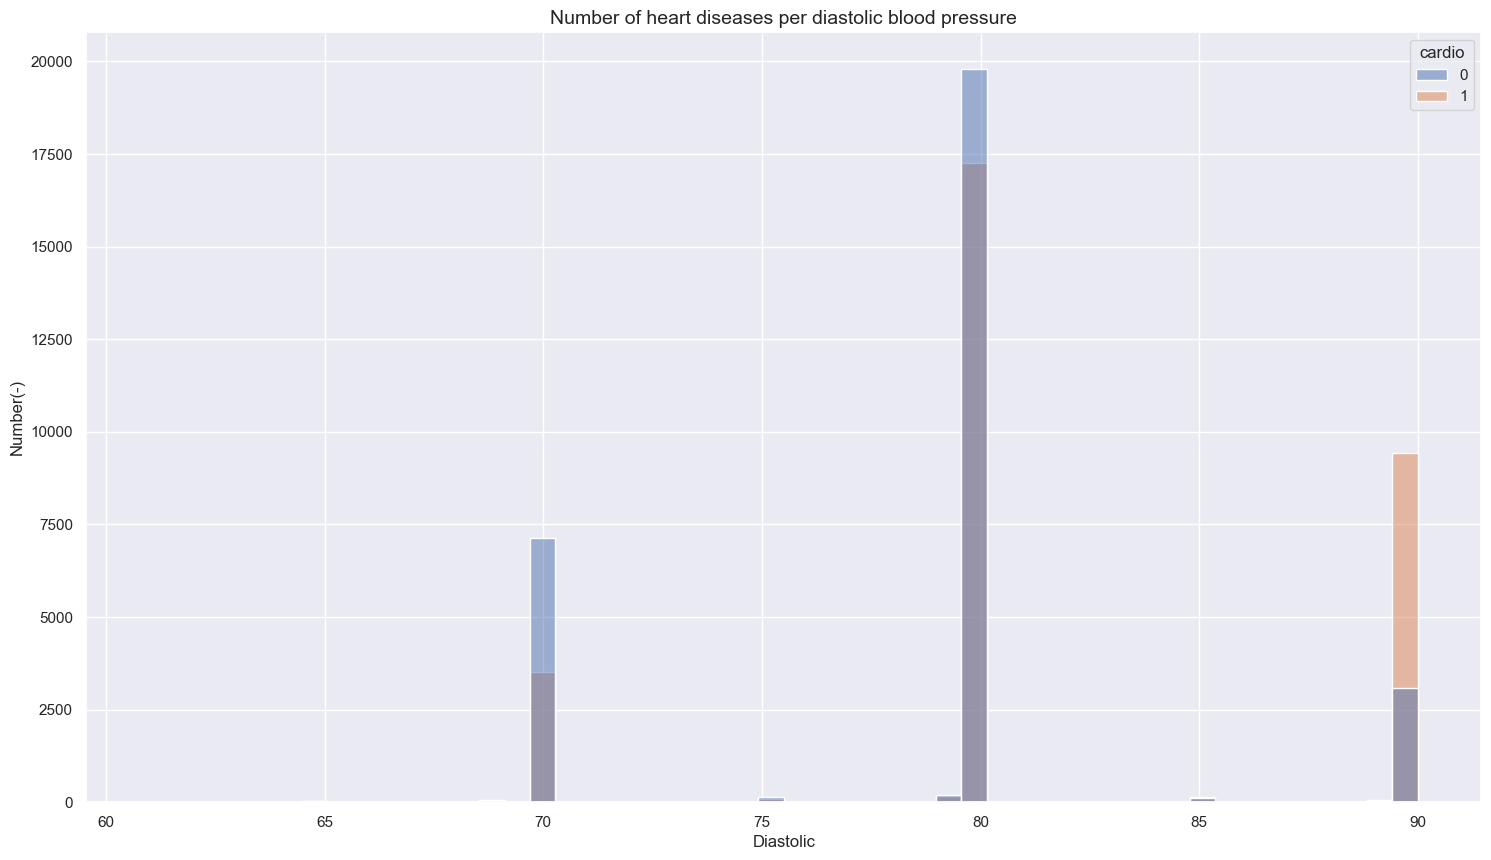

In [101]:
# sets plot size
plt.figure(figsize=(18,10))

# plots countplot
_ = sns.histplot(x='ap_lo', hue='cardio', data=df4, bins=50)

# sets plot features
plt.title("Number of heart diseases per diastolic blood pressure", fontsize=14)
plt.xlabel("Diastolic")
plt.ylabel("Number(-)")

# display plot
plt.show()

- We have more cases for diastolic equals to 80;
- However, diastolic equals to 90 are more prone to have heart diseases.

## 4.3. Multivariate analysis

### 4.3.1. Data type split

We'll consider to be numerical:

- age, height, weight, ap_hi, ap_lo, bmi and bmi_diff.

We'll consider to be categorical:

- gender, cholesterol, gluc and blood_pressure.

We'll consider to be binary:

- smoke, alco and active.

Target: 

- cardio.

In [103]:
# numerical attributes
numerical_vars = df4[['age','height','weight','ap_hi','ap_lo', 'bmi', 'bmi_diff']]

# categorical attributes
categorical_vars = df4[['gender','cholesterol','gluc', 'blood_pressure']]

# binary attributes
binary_vars = df4[['smoke','alco','active']]

Type transformations in order be easier to make the correlations:

In [104]:
# sets string categories for gender
categorical_vars['gender'] = categorical_vars['gender'].apply(lambda x: 'F' if x == 1 else 'M')

# converts gender to categorical dtype
categorical_vars['gender'] = categorical_vars['gender'].astype('category')

# sets string categories for cholesterol
categorical_vars['cholesterol'] = categorical_vars['cholesterol'].apply(lambda x: 'normal' if x == 1 
                                                                        else 'above normal' if x == 2 
                                                                        else 'well above normal')

# converts cholesterol to categorical dtype
categorical_vars['cholesterol'] = categorical_vars['cholesterol'].astype('category')

# sets string categories for glucose
categorical_vars['gluc'] = categorical_vars['gluc'].apply(lambda x: 'normal' if x == 1 
                                                                else 'above normal' if x == 2 
                                                                else 'well above normal')
# converts glucose to categorical dtype
categorical_vars['gluc'] = categorical_vars['gluc'].astype('category')

/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_18665/3587491192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_vars['gender'] = categorical_vars['gender'].apply(lambda x: 'F' if x == 1 else 'M')
/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_18665/3587491192.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_vars['gender'] = categorical_vars['gender'].astype('category')
/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_18665/3587491192.py:8: Set

### 4.3.2. Numerical correlations

In [105]:
# checks numerical info
numerical_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61720 entries, 0 to 61719
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       61720 non-null  int64  
 1   height    61720 non-null  int64  
 2   weight    61720 non-null  float64
 3   ap_hi     61720 non-null  int64  
 4   ap_lo     61720 non-null  int64  
 5   bmi       61720 non-null  float64
 6   bmi_diff  61720 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 3.3 MB


/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_18665/3383852058.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(correlations, dtype=np.bool))


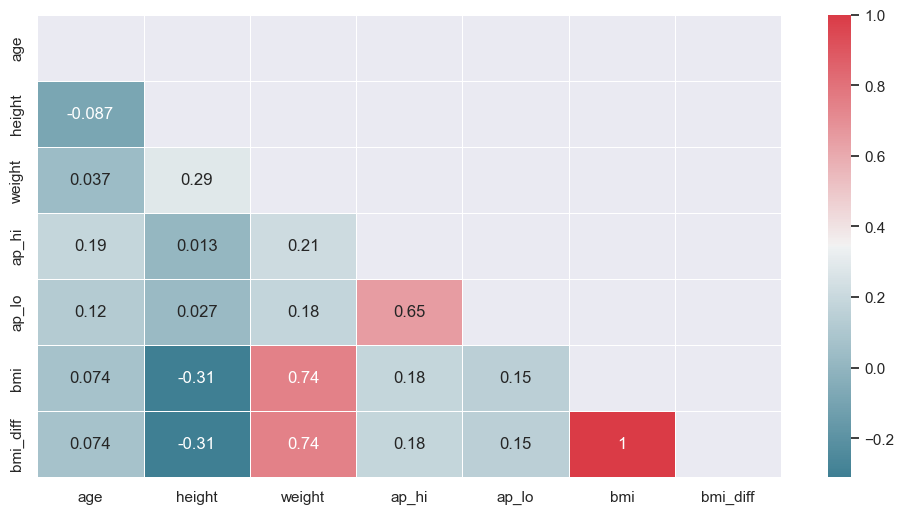

In [107]:
# calculates the correlations
correlations = numerical_vars.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# generates a mask for the upper triangle
mask = np.triu(np.ones_like(correlations, dtype=np.bool))

# generates a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plots the heatmap
sns.heatmap(correlations, cmap=cmap, mask=mask, linewidths=.5, annot=True)

# displays the plot
plt.show()

The strongest correlations above were expected:

1. bmi and bmi_diff. (1)
2. bmi and weight. (0.74)
3. bmi_diff and weight. (0.74)
4. ap_lo and ap_hi. (0.65)

### 4.3.3. Binary and numerical correlations

In [108]:
# checks binary info
binary_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61720 entries, 0 to 61719
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   smoke   61720 non-null  int64
 1   alco    61720 non-null  int64
 2   active  61720 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


In [109]:
# displays the numerical vars
numerical_vars.columns

Index(['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'bmi_diff'], dtype='object')

In [110]:
# makes all the possible combinations between attributes
a1 = pointbiserialr(binary_vars['smoke'], numerical_vars['age'])[0]
a2 = pointbiserialr(binary_vars['smoke'], numerical_vars['height'])[0]
a3 = pointbiserialr(binary_vars['smoke'], numerical_vars['weight'])[0]
a4 = pointbiserialr(binary_vars['smoke'], numerical_vars['ap_hi'])[0]
a5 = pointbiserialr(binary_vars['smoke'], numerical_vars['ap_lo'])[0]
a6 = pointbiserialr(binary_vars['smoke'], numerical_vars['bmi'])[0]
a7 = pointbiserialr(binary_vars['smoke'], numerical_vars['bmi_diff'])[0]

a8 = pointbiserialr(binary_vars['alco'], numerical_vars['age'])[0]
a9 = pointbiserialr(binary_vars['alco'], numerical_vars['height'])[0]
a10 = pointbiserialr(binary_vars['alco'], numerical_vars['weight'])[0]
a11 = pointbiserialr(binary_vars['alco'], numerical_vars['ap_hi'])[0]
a12 = pointbiserialr(binary_vars['alco'], numerical_vars['ap_lo'])[0]
a13 = pointbiserialr(binary_vars['alco'], numerical_vars['bmi'])[0]
a14 = pointbiserialr(binary_vars['alco'], numerical_vars['bmi_diff'])[0]

a15 = pointbiserialr(binary_vars['active'], numerical_vars['age'])[0]
a16 = pointbiserialr(binary_vars['active'], numerical_vars['height'])[0]
a17 = pointbiserialr(binary_vars['active'], numerical_vars['weight'])[0]
a18 = pointbiserialr(binary_vars['active'], numerical_vars['ap_hi'])[0]
a19 = pointbiserialr(binary_vars['active'], numerical_vars['ap_lo'])[0]
a20 = pointbiserialr(binary_vars['active'], numerical_vars['bmi'])[0]
a21 = pointbiserialr(binary_vars['active'], numerical_vars['bmi_diff'])[0]

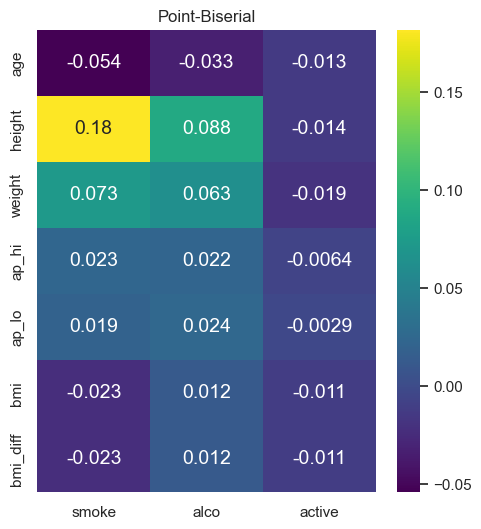

In [113]:
# creates a DataFrame to store the values
df_pbs_r = pd.DataFrame({'smoke':[a1, a2, a3, a4, a5, a6, a7],
                         'alco':[a8, a9, a10, a11, a12, a13, a14],
                         'active':[a15, a16, a17, a18, a19, a20, a21]})

# sets the index equal to columns
df_pbs_r = df_pbs_r.set_index(numerical_vars.columns)


# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# plots the heatmap
plt.subplot(1,2,1)
sns.heatmap(df_pbs_r, annot=True, annot_kws={"fontsize":14}, cmap='viridis')
plt.title("Point-Biserial")

# displays plot
plt.show()

They have very weak correlations. Yet, the strongest correlations are:

1. height and smoke. (0.18)
2. height and alco. (0.088)
3. weight and smoke. (0.073)

### 4.3.4. Categorical correlations

In [114]:
# checks categorical info
categorical_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61720 entries, 0 to 61719
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   gender          61720 non-null  category
 1   cholesterol     61720 non-null  category
 2   gluc            61720 non-null  category
 3   blood_pressure  61720 non-null  object  
dtypes: category(3), object(1)
memory usage: 663.5+ KB


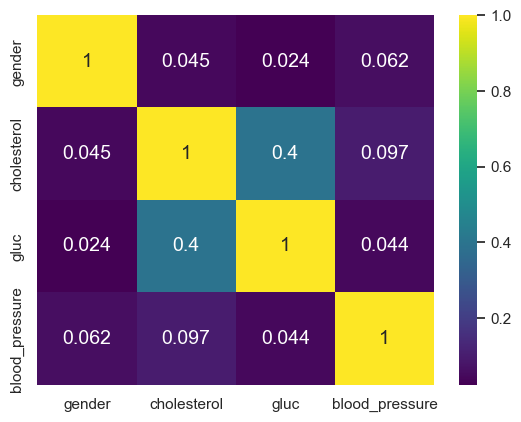

In [125]:
# makes all the possible combinations between categorical attributes
a1 = cramers_v(categorical_vars['gender'], categorical_vars['gender'])
a2 = cramers_v(categorical_vars['gender'], categorical_vars['cholesterol'])
a3 = cramers_v(categorical_vars['gender'], categorical_vars['gluc'])
a4 = cramers_v(categorical_vars['gender'], categorical_vars['blood_pressure'])

a5 = cramers_v(categorical_vars['cholesterol'], categorical_vars['gender'])
a6 = cramers_v(categorical_vars['cholesterol'], categorical_vars['cholesterol'])
a7 = cramers_v(categorical_vars['cholesterol'], categorical_vars['gluc'])
a8 = cramers_v(categorical_vars['cholesterol'], categorical_vars['blood_pressure'])

a9 = cramers_v(categorical_vars['gluc'], categorical_vars['gender'])
a10 = cramers_v(categorical_vars['gluc'], categorical_vars['cholesterol'])
a11 = cramers_v(categorical_vars['gluc'], categorical_vars['gluc'])
a12 = cramers_v(categorical_vars['gluc'], categorical_vars['blood_pressure'])

a13 = cramers_v(categorical_vars['blood_pressure'], categorical_vars['gender'])
a14 = cramers_v(categorical_vars['blood_pressure'], categorical_vars['cholesterol'])
a15 = cramers_v(categorical_vars['blood_pressure'], categorical_vars['gluc'])
a16 = cramers_v(categorical_vars['blood_pressure'], categorical_vars['blood_pressure'])

# creates a DataFrame to store the correlations values
df_cramers_v = pd.DataFrame({'gender': [a1, a2, a3, a4],
                            'cholesterol':[a5, a6, a7, a8],
                            'gluc':[a9, a10, a11, a12],
                            'blood_pressure':[a13, a14, a15, a16]})

# sets the index equal to columns
df_cramers_v = df_cramers_v.set_index(df_cramers_v.columns)
sns.heatmap(df_cramers_v, annot=True, annot_kws={"fontsize":14}, cmap='viridis');

All of them have very weak correlation. Yet, the strongest correlations are:

1. cholesterol and glucose.
2. blood_pressure and cholesterol.
3. blood_pressure and gender.

# 5. Data Preprocessing

In [126]:
df5 = df4.copy()

In [127]:
df5.sample(3)

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
58273   58       1     169   69.00    120     80            1     3      0   
38655   60       1     170   69.00    130     80            1     1      0   
21476   57       1     175   76.00    110     80            1     1      0   

       alco  active   bmi  bmi_diff bmi_class  blood_pressure  cardio  
58273     0       1 24.16      1.21    normal  high stage one       1  
38655     0       1 23.88      0.93    normal  high stage one       0  
21476     0       1 24.82      1.87    normal  high stage one       0

## 5.1. Attributes categorization

In [128]:
# sets string categories for gender
df5['gender'] = df5['gender'].apply(lambda x: 'F' if x == 1 else 'M')


# sets string categories for glucose
df5['gluc'] = df5['gluc'].apply(lambda x: 'normal' if x == 1 
                                      else 'above normal' if x == 2 
                                      else 'well above normal')


# sets string categories for cholesterol
df5['cholesterol'] = df5['cholesterol'].apply(lambda x: 'normal' if x == 1 
                                                    else 'above normal' if x == 2 
                                                    else 'well above normal')

## 5.2. Train and test split

In [129]:
# separates data
X = df5.drop(['cardio'], axis=1).copy()
y = df5[['cardio']].copy()

In [130]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED, stratify=y)

## 5.3. Scaling

In [131]:
# separates the vars that will be scaled
train_vars_to_scale = X_train[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'bmi_diff']]
test_vars_to_scale = X_test[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'bmi_diff']]

In [132]:
# instantiates the scaler
mms_scaler = MinMaxScaler()

In [133]:
# scales the data
mms_scaler.fit(train_vars_to_scale)
train_numerical_scaled = mms_scaler.transform(train_vars_to_scale)
test_numerical_scaled = mms_scaler.transform(test_vars_to_scale)

In [134]:
# converts scaled data to DataFrame for better readability
train_numerical_scaled = pd.DataFrame(train_numerical_scaled, columns=train_vars_to_scale.columns)
test_numerical_scaled = pd.DataFrame(test_numerical_scaled, columns=test_vars_to_scale.columns)

## 5.4. Transformation

### 5.4.1. Encoding categorical data

We used one hot encoding since gender has only two categories.

In [158]:
# gets categorical vars
train_categorical_vars = X_train[['gender']]
test_categorical_vars = X_test[['gender']]

# resets the index
train_categorical_vars.reset_index(drop=True, inplace=True)
test_categorical_vars.reset_index(drop=True, inplace=True)

# one hot encoding - just 2 categories
train_categorical_encoded = pd.get_dummies(train_categorical_vars)
test_categorical_encoded = pd.get_dummies(test_categorical_vars)

In [159]:
# As the binary vars are already encoded as 1s and 0s, there is no need to do the one-hot encoding
train_binary_vars = X_train[['smoke','alco','active']]
test_binary_vars = X_test[['smoke','alco','active']]

# resets index
train_binary_vars.reset_index(drop=True, inplace=True)
test_binary_vars.reset_index(drop=True, inplace=True)

### 5.4.2. Frequency encoding categorical data - training dataset

We usually use frequency encoding for those variables with many categories.

In [160]:
X_train['cholesterol'].value_counts()

normal               35348
above normal          5647
well above normal     5295
Name: cholesterol, dtype: int64

In [161]:
X_train['gluc'].value_counts()

normal               39589
well above normal     3597
above normal          3104
Name: gluc, dtype: int64

In [162]:
X_train['blood_pressure'].value_counts()

high stage one    31756
high stage two     6666
normal             5751
elevated           2117
Name: blood_pressure, dtype: int64

In [163]:
 # filtering categorical attributes
train_cat_att_freq = X_train[['cholesterol','gluc','blood_pressure']]

# reseting the index
train_cat_att_freq.reset_index(drop=True, inplace=True)

In [164]:
# creating a dictionary from value counts
count_dict_cholesterol = train_cat_att_freq['cholesterol'].value_counts().to_dict()

# storing values as DataFrame
df_count_cholesterol = pd.DataFrame(count_dict_cholesterol.items(), columns=['Value','Count'])

# calculating the frequency for each value
df_count_cholesterol['frequency'] = df_count_cholesterol['Count']/df_count_cholesterol['Count'].sum()

# creating a dictionary from value counts
count_dict_gluc = train_cat_att_freq['gluc'].value_counts().to_dict()

# storing values as DataFrame
df_count_gluc = pd.DataFrame(count_dict_gluc.items(), columns=['Value','Count'])

# calculating the frequency for each value
df_count_gluc['frequency'] = df_count_gluc['Count']/df_count_gluc['Count'].sum()

# creating a dictionary from value counts
count_dict_blood_pressure = train_cat_att_freq['blood_pressure'].value_counts().to_dict()

# storing values as DataFrame
df_count_blood_pressure = pd.DataFrame(count_dict_blood_pressure.items(), columns=['Value','Count'])

# calculating the frequency for each value
df_count_blood_pressure['frequency'] = df_count_blood_pressure['Count']/df_count_blood_pressure['Count'].sum()

In [165]:
# creating a dictionary for the frequency
frequency_cholesterol = df_count_cholesterol.set_index('Value').to_dict()['frequency']
frequency_gluc = df_count_gluc.set_index('Value').to_dict()['frequency']
frequency_blood_pressure = df_count_blood_pressure.set_index('Value').to_dict()['frequency']

In [166]:
# creating an empty DataFrame
train_cat_attr_freq_encoded = pd.DataFrame()

# creating columns for frequency
train_cat_attr_freq_encoded['cholesterol'] =  train_cat_att_freq['cholesterol'].map(frequency_cholesterol)
train_cat_attr_freq_encoded['gluc'] =  train_cat_att_freq['gluc'].map(frequency_gluc)
train_cat_attr_freq_encoded['blood_pressure'] =  train_cat_att_freq['blood_pressure'].map(frequency_blood_pressure)

In [167]:
train_cat_attr_freq_encoded.sample(3)

cholesterol  gluc  blood_pressure
21435         0.12  0.86            0.69
8985          0.11  0.86            0.69
13317         0.12  0.86            0.14

### 5.4.3. Training datasets concatenation 

In [168]:
X_train_prep = pd.concat([train_numerical_scaled, 
                          train_binary_vars, 
                          train_categorical_encoded, 
                          train_cat_attr_freq_encoded], axis=1) 

In [169]:
X_train_prep.head(3)

age  height  weight  ap_hi  ap_lo  bmi  bmi_diff  smoke  alco  active  \
0 0.74    0.69    0.24   0.57   0.66 0.06      0.06      0     0       1   
1 0.69    0.79    0.22   0.36   0.31 0.04      0.04      0     0       1   
2 0.31    0.64    0.33   0.79   1.00 0.09      0.09      0     0       1   

   gender_F  gender_M  cholesterol  gluc  blood_pressure  
0         1         0         0.76  0.86            0.69  
1         1         0         0.76  0.86            0.12  
2         1         0         0.76  0.08            0.69

### 5.4.4. Frequency encoding categorical data - test dataset

In [171]:
# filters categorical attributes
test_cat_att_freq = X_test[['cholesterol','gluc','blood_pressure']]

# resets the index
test_cat_att_freq.reset_index(drop=True, inplace=True)

In [172]:
# creating a dictionary from value counts
count_dict_cholesterol = test_cat_att_freq['cholesterol'].value_counts().to_dict()

# storing values as DataFrame
df_count_cholesterol = pd.DataFrame(count_dict_cholesterol.items(), columns=['Value','Count'])

# calculating the frequency for each value
df_count_cholesterol['frequency'] = df_count_cholesterol['Count']/df_count_cholesterol['Count'].sum()

# creating a dictionary from value counts
count_dict_gluc = test_cat_att_freq['gluc'].value_counts().to_dict()

# storing values as DataFrame
df_count_gluc = pd.DataFrame(count_dict_gluc.items(), columns=['Value','Count'])

# calculating the frequency for each value
df_count_gluc['frequency'] = df_count_gluc['Count']/df_count_gluc['Count'].sum()

# creating a dictionary from value counts
count_dict_blood_pressure = test_cat_att_freq['blood_pressure'].value_counts().to_dict()

# storing values as DataFrame
df_count_blood_pressure = pd.DataFrame(count_dict_blood_pressure.items(), columns=['Value','Count'])

# calculating the frequency for each value
df_count_blood_pressure['frequency'] = df_count_blood_pressure['Count']/df_count_blood_pressure['Count'].sum()

In [173]:
# gets a dictionary for the frequency
frequency_cholesterol = df_count_cholesterol.set_index('Value').to_dict()['frequency']
frequency_gluc = df_count_gluc.set_index('Value').to_dict()['frequency']
frequency_blood_pressure = df_count_blood_pressure.set_index('Value').to_dict()['frequency']

In [174]:
# creating an empty DataFrame
test_cat_attr_freq_encoded = pd.DataFrame()

# creating a columns for frequency
test_cat_attr_freq_encoded['cholesterol'] =  test_cat_att_freq['cholesterol'].map(frequency_cholesterol)
test_cat_attr_freq_encoded['gluc'] =  test_cat_att_freq['gluc'].map(frequency_gluc)
test_cat_attr_freq_encoded['blood_pressure'] =  test_cat_att_freq['blood_pressure'].map(frequency_blood_pressure)

In [175]:
test_cat_attr_freq_encoded.sample(3)

cholesterol  gluc  blood_pressure
1555          0.76  0.06            0.68
10992         0.76  0.86            0.68
427           0.76  0.86            0.68

### 5.4.5. Test datasets concatenation

In [176]:
# concatenating the data sets
X_test_prep = pd.concat([test_numerical_scaled, 
                         test_binary_vars, 
                         test_categorical_encoded, 
                         test_cat_attr_freq_encoded], axis=1)

In [177]:
X_test_prep.sample(3)

age  height  weight  ap_hi  ap_lo  bmi  bmi_diff  smoke  alco  active  \
3417 0.63    0.74    0.27   0.79   0.66 0.06      0.06      0     0       0   
7364 0.29    0.68    0.38   0.36   0.66 0.09      0.09      0     0       1   
142  0.63    0.76    0.26   0.36   0.66 0.05      0.05      1     0       1   

      gender_F  gender_M  cholesterol  gluc  blood_pressure  
3417         0         1         0.76  0.86            0.68  
7364         1         0         0.76  0.86            0.68  
142          1         0         0.13  0.86            0.68

# 6. Feature Selection

In [178]:
# define RandomForestClassifier
# uses all cores from CPU
rf_clf = RandomForestClassifier(n_jobs=-1)
extra_clf = ExtraTreesClassifier(n_jobs=-1) 

In [179]:
# define Boruta
boruta_et = BorutaPy(extra_clf, 
                  n_estimators='auto', 
                  verbose=2, 
                  random_state=SEED).fit(X_train_prep.values, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	2
Tentative: 	2
Rejected: 	11
I

In [180]:
# define Boruta
boruta_rf = BorutaPy(rf_clf, 
                  n_estimators='auto', 
                  verbose=2, 
                  random_state=SEED).fit(X_train_prep.values, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	13


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	13


In [181]:
# getting the ranked list of features
cols_selected = boruta_et.support_.tolist()
cols_selected_boruta = X_train_prep.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['age', 'weight', 'ap_hi', 'bmi_diff']

Boruta selection included 4 attributes by using Extra Trees Classifier.

In [182]:
# creating a dataset with only the cols selected by boruta
X_train_prep_boruta = X_train_prep[cols_selected_boruta].copy()
X_test_prep_boruta = X_test_prep[cols_selected_boruta].copy()

/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_18665/692917295.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  extra_clf.fit(X_train_prep, y_train)


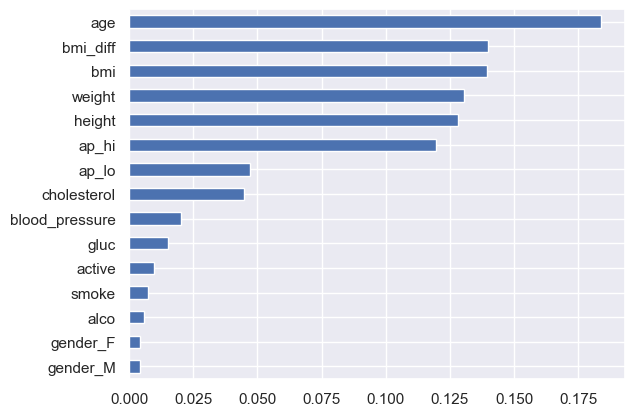

In [184]:
# checking feature importances
extra_clf.fit(X_train_prep, y_train)

feat_importances = pd.Series(extra_clf.feature_importances_, index=X_train_prep.columns)
feat_importances.sort_values().plot(kind='barh');

By feature importances, we found that the most important features are:
1. age.
2. bmi_diff.
3. bmi.
4. weight.
5. height.
6. ap_hi.

Based on the results, we well select three groups to train the model:

    1. Boruta selection by extra tree classifier, since it came up with more features: age, weight, ap_hi and bmi_diff. 
    2. Features selected by feature importance: age, bmi_diff, bmi, weight, height and ap_hi. 
    3. All of the features. 

The decision in order to find the best dataset will be made based on the performance.

# 7. Machine Learning Modelling

In [214]:
df7 = df5.copy()

## 7.1. Baseline model 

For a classification problem, we may use the baseline model which randomly estimates the classes we are looking at (target).

### 7.1.1. Boruta selection

In [229]:
# Copying dataset
df = df7[["age", "weight", "ap_hi", "bmi_diff", "cardio"]].copy()

In [230]:
# population is the response variable - it is in the alphabetic order for the classes
target_list = df7['cardio'].drop_duplicates().sort_values().tolist()

# number of samples generated randomly is the number of predictions we want = y_test.shape[0]
k_num = y_test.shape[0]

# number of classes - it is in the alphabetic order fot the classes
target_weights = df['cardio'].value_counts( normalize=True ).sort_index().tolist()

# predictions
yhat_random = random.choices( population=target_list,  
                              weights=target_weights,
                              k=k_num )
len(yhat_random)

15430

Accuracy: 0.5062216461438755
Balanced Accuracy: 0.5062216461438755
Kappa Score: 0.012443292287751095
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      7715
           1       0.51      0.51      0.51      7715

    accuracy                           0.51     15430
   macro avg       0.51      0.51      0.51     15430
weighted avg       0.51      0.51      0.51     15430



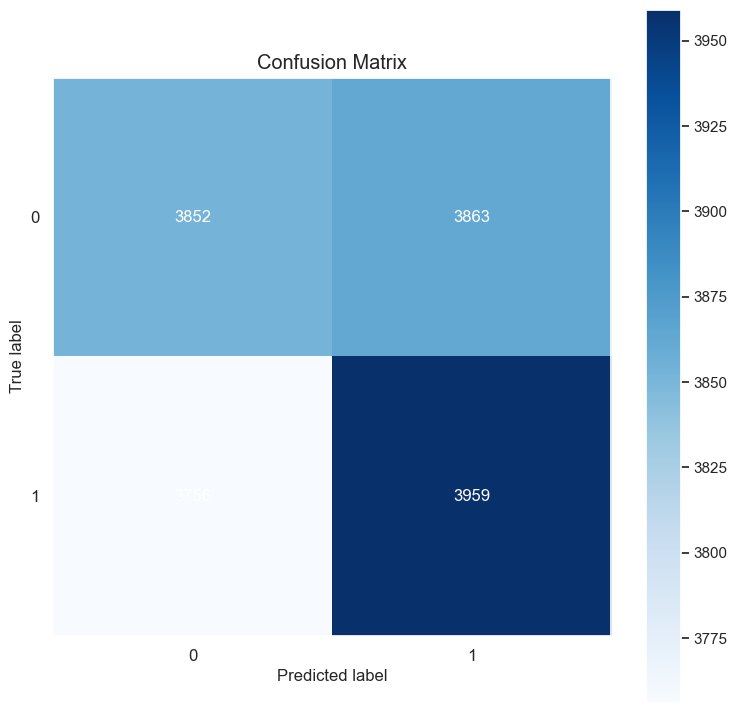

In [231]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(9,9));

### 7.1.2. Feature importance selection

In [232]:
# Copying dataset
df = df7[["age", "weight", "height", "ap_hi", "bmi", "bmi_diff", "cardio"]].copy()

In [233]:
# population is the response variable - it is in the alphabetic order for the classes
target_list = df['cardio'].drop_duplicates().sort_values().tolist()

# number of samples generated randomly is the number of predictions we want = y_test.shape[0]
k_num = y_test.shape[0]

# number of classes - it is in the alphabetic order fot the classes
target_weights = df['cardio'].value_counts( normalize=True ).sort_index().tolist()

# predictions
yhat_random = random.choices( population=target_list,  
                              weights=target_weights,
                              k=k_num )
len(yhat_random)

15430

Accuracy: 0.49734283862605316
Balanced Accuracy: 0.4973428386260531
Kappa Score: -0.005314322747893785
              precision    recall  f1-score   support

           0       0.50      0.49      0.50      7715
           1       0.50      0.50      0.50      7715

    accuracy                           0.50     15430
   macro avg       0.50      0.50      0.50     15430
weighted avg       0.50      0.50      0.50     15430



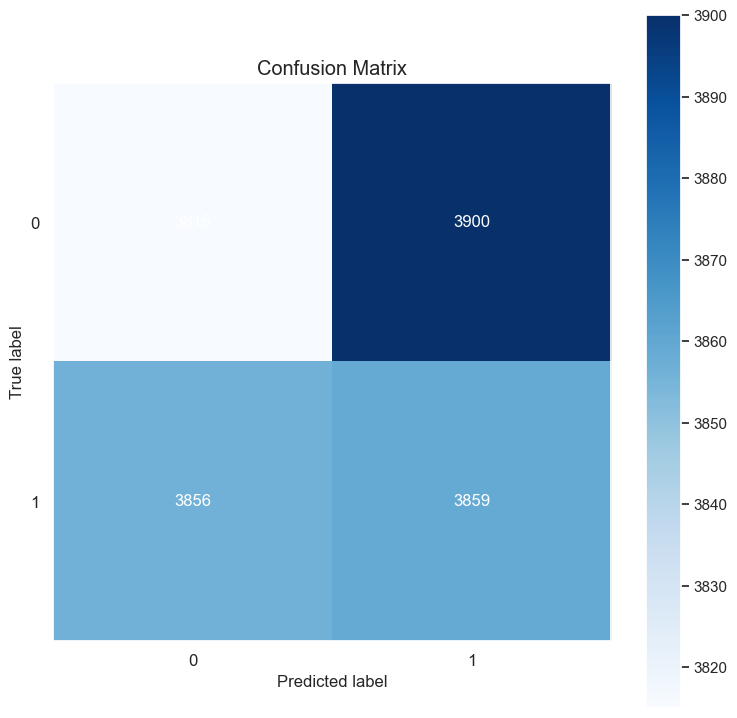

In [234]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(9,9));

### 7.1.3. All features

In [235]:
# Copying dataset
df = df7.copy()

In [236]:
# population is the response variable - it is in the alphabetic order for the classes
target_list = df['cardio'].drop_duplicates().sort_values().tolist()

# number of samples generated randomly is the number of predictions we want = y_test.shape[0]
k_num = y_test.shape[0]

# number of classes - it is in the alphabetic order fot the classes
target_weights = df['cardio'].value_counts( normalize=True ).sort_index().tolist()

# predictions
yhat_random = random.choices( population=target_list,  
                              weights=target_weights,
                              k=k_num )
len(yhat_random)

15430

Accuracy: 0.50349967595593
Balanced Accuracy: 0.50349967595593
Kappa Score: 0.006999351911859963
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      7715
           1       0.50      0.51      0.51      7715

    accuracy                           0.50     15430
   macro avg       0.50      0.50      0.50     15430
weighted avg       0.50      0.50      0.50     15430



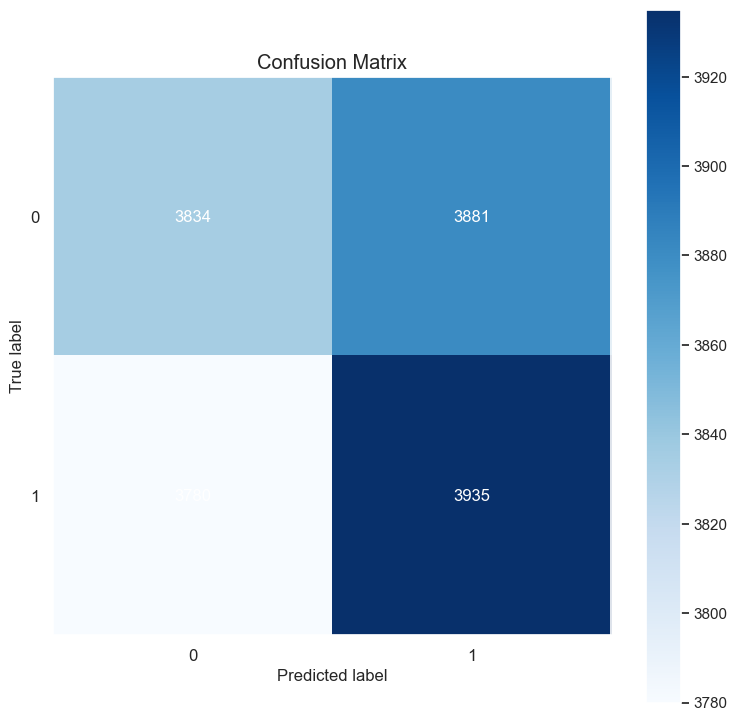

In [237]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(9,9));

## 7.2. Logistic Regression

### 7.2.1. Boruta selection

In [256]:
# Logistic model
logreg = LogisticRegression(class_weight='balanced', random_state=123)
logreg.fit(X_train_prep[["age", "weight", "ap_hi", "bmi_diff"]], 
           y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', random_state=123)

In [257]:
preds = logreg.predict_proba(X_test_prep[["age", "weight", "ap_hi", "bmi_diff"]])[:,1]
print(preds)
print("Test ROC-AUC:" + str(metrics.roc_auc_score(y_test, preds)))

[0.73548292 0.37764723 0.87548409 ... 0.59834113 0.69852216 0.35875319]
Test ROC-AUC:0.7397462585825476


In [258]:
preds.shape

(15430,)

- As we have 15430, the results above are the probabilities of 15430 users to purchase or not.
- A high ROC-AUC is a good sign.

In [259]:
preds_label = logreg.predict(X_test_prep[["age", "weight", "ap_hi", "bmi_diff"]])
print(preds_label)
print("Test Accuracy:" + str(metrics.accuracy_score(y_test,preds_label)))

[1 0 1 ... 1 1 0]
Test Accuracy:0.6803629293583927


- The accuracy is better than the current maximum of 65%.

In [260]:
pd.DataFrame(zip(X_train_prep[["age", "weight", "ap_hi", "bmi_diff"]].columns,logreg.coef_[0]), 
             columns=['Feats','Imp']).sort_values(by='Imp',ascending=False)

Feats  Imp
2     ap_hi 3.64
3  bmi_diff 2.64
0       age 2.16
1    weight 1.57

As we see, by logistic classifier we have ap_hi as the most important feature. The sequence may be seen in the table above.

### 7.2.2. Feature importance selection

In [261]:
# Logistic model
logreg = LogisticRegression(class_weight='balanced', random_state=123)
logreg.fit(X_train_prep[["age", "weight", "height", "ap_hi", "bmi", "bmi_diff"]], 
           y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', random_state=123)

In [262]:
preds = logreg.predict_proba(X_test_prep[["age", "weight", "height", "ap_hi", "bmi", "bmi_diff"]])[:,1]
print(preds)
print("Test ROC-AUC:" + str(metrics.roc_auc_score(y_test, preds)))

[0.75100964 0.3848714  0.87729826 ... 0.58829629 0.70240674 0.34660342]
Test ROC-AUC:0.7401653023774293


In [263]:
preds_label = logreg.predict(X_test_prep[["age", "weight", "height", "ap_hi", "bmi", "bmi_diff"]])
print(preds_label)
print("Test Accuracy:" + str(metrics.accuracy_score(y_test,preds_label)))

[1 0 1 ... 1 1 0]
Test Accuracy:0.6806221646143875


In [264]:
pd.DataFrame(zip(X_train_prep[["age", "weight", "height", "ap_hi", "bmi", "bmi_diff"]].columns,logreg.coef_[0]), 
             columns=['Feats','Imp']).sort_values(by='Imp',ascending=False)

Feats   Imp
3     ap_hi  3.63
1    weight  2.41
0       age  2.14
4       bmi -0.17
5  bmi_diff -0.17
2    height -1.45

- We have a better performance for feature importance selection.
- Logistic regression determined ap_hi as the most important feature.

### 7.2.3. All features

In [265]:
# Logistic model
logreg = LogisticRegression(class_weight='balanced', random_state=123)
logreg.fit(X_train_prep, 
           y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=123)

In [266]:
preds = logreg.predict_proba(X_test_prep)[:,1]
print(preds)
print("Test ROC-AUC:" + str(metrics.roc_auc_score(y_test, preds)))

[0.70535468 0.39540185 0.88255398 ... 0.58820191 0.62098715 0.30624895]
Test ROC-AUC:0.7549320767507726


In [267]:
preds_label = logreg.predict(X_test_prep)
print(preds_label)
print("Test Accuracy:" + str(metrics.accuracy_score(y_test,preds_label)))

[1 0 1 ... 1 1 0]
Test Accuracy:0.6921581335061568


In [268]:
pd.DataFrame(zip(X_train_prep.columns,logreg.coef_[0]), 
             columns=['Feats','Imp']).sort_values(by='Imp',ascending=False)

Feats   Imp
3            ap_hi  3.22
0              age  2.07
2           weight  1.93
4            ap_lo  0.59
13            gluc  0.05
6         bmi_diff  0.05
5              bmi  0.05
10        gender_F -0.09
11        gender_M -0.13
7            smoke -0.19
9           active -0.26
8             alco -0.29
1           height -0.50
14  blood_pressure -0.50
12     cholesterol -1.07

- We have better performance by using all features in Logistic Regression.
- ap_hi seems to be the most important feature for this model.
- 69% of accuracy is better than the current maximum of 65%.

## 7.3. Random Forest

### 7.3.1. Boruta selection

In [275]:
y_train_rf = y_train.values.reshape(-1, 1)

# model and training
rf = RandomForestRegressor(n_estimators=100, 
                           n_jobs=-1, 
                           random_state=42, 
                           verbose=4).fit(X_train_prep[["age", "weight", "ap_hi", "bmi_diff"]], 
                                          y_train_rf)

/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_18665/1034870214.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestRegressor(n_estimators=100,
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100building tree 26 of 100

building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


In [276]:
# prediction
pred_rf = rf.predict(X_test_prep[["age", "weight", "ap_hi", "bmi_diff"]])

# invert prediction - going back to the categorical attributes 
# real prediction
yhat_rf = pred_rf

# prediction prepare
y_test_rf = y_test.to_numpy()
yhat_rf = yhat_rf.reshape(1, -1)[0]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy: 0.6756966947504861
Balanced Accuracy: 0.6756966947504861
Kappa Score: 0.3513933895009721
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      7715
           1       0.67      0.69      0.68      7715

    accuracy                           0.68     15430
   macro avg       0.68      0.68      0.68     15430
weighted avg       0.68      0.68      0.68     15430



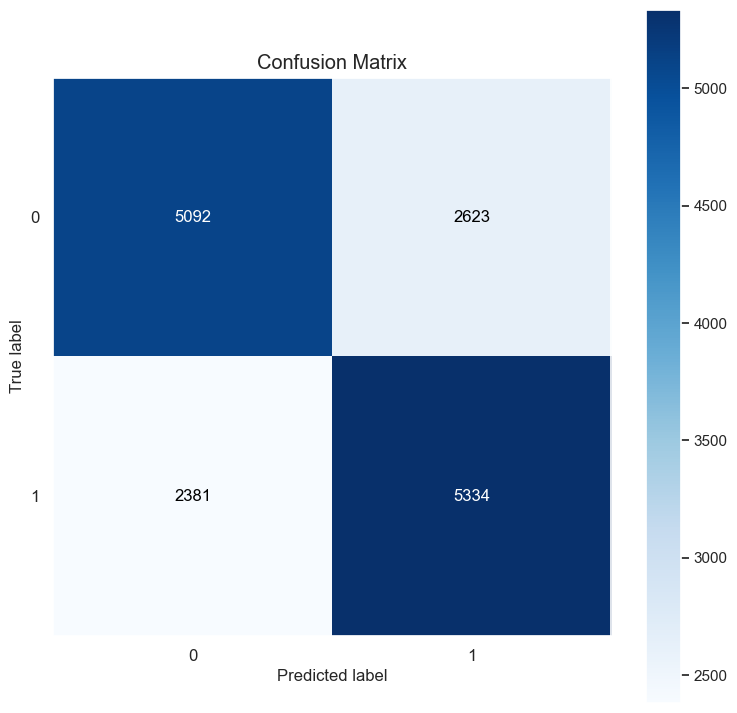

In [277]:
# Convert continuous targets to binary targets
y_test_rf_binary = np.round(y_test_rf)
yhat_rf_binary = np.round(yhat_rf)

# Accuracy
acc_rf = m.accuracy_score(y_test_rf_binary, yhat_rf_binary)
print('Accuracy: {}'.format(acc_rf))

# Balanced Accuray
balanced_acc_rf = m.balanced_accuracy_score(y_test_rf_binary, yhat_rf_binary)
print('Balanced Accuracy: {}'.format(balanced_acc_rf))

# Kappa Metrics
kappa_rf = m.cohen_kappa_score(y_test_rf_binary, yhat_rf_binary)
print('Kappa Score: {}'.format(kappa_rf))

# Classification report
print(m.classification_report(y_test_rf_binary, yhat_rf_binary))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_rf_binary, yhat_rf_binary, normalize=False, figsize=(9,9));

### 7.3.2. Feature importance selection

In [278]:
y_train_rf = y_train.values.reshape(-1, 1)

# model and training
rf = RandomForestRegressor(n_estimators=100, 
                           n_jobs=-1, 
                           random_state=42, 
                           verbose=4).fit(X_train_prep[["age", "weight", "height", "ap_hi", "bmi", "bmi_diff"]], 
                                          y_train_rf)

/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_18665/1057082378.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestRegressor(n_estimators=100,
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s


building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.2s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


In [279]:
# prediction
pred_rf = rf.predict(X_test_prep[["age", "weight", "height", "ap_hi", "bmi", "bmi_diff"]])

# invert prediction - going back to the categorical attributes 
# real prediction
yhat_rf = pred_rf

# prediction prepare
y_test_rf = y_test.to_numpy()
yhat_rf = yhat_rf.reshape(1, -1)[0]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy: 0.6755022683084899
Balanced Accuracy: 0.6755022683084899
Kappa Score: 0.35100453661697995
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      7715
           1       0.67      0.69      0.68      7715

    accuracy                           0.68     15430
   macro avg       0.68      0.68      0.68     15430
weighted avg       0.68      0.68      0.68     15430



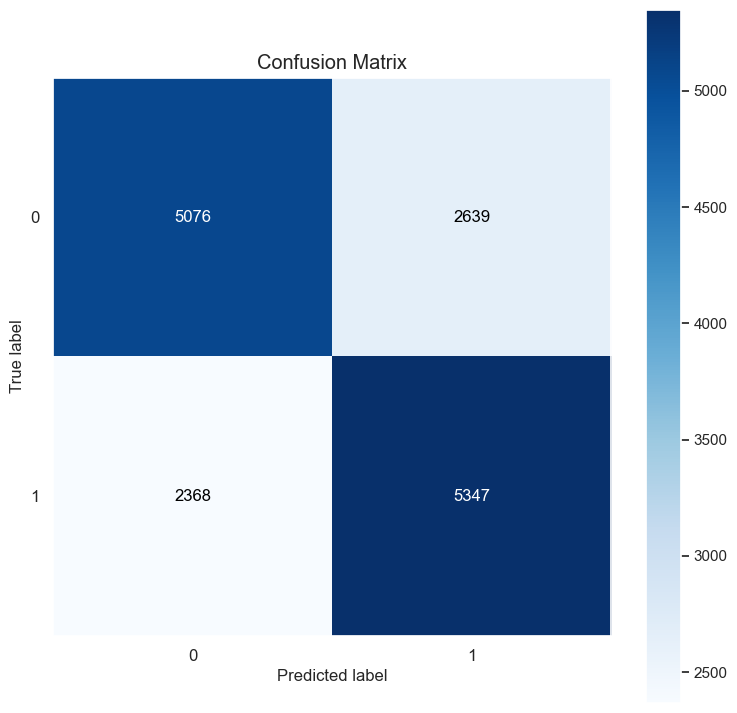

In [280]:
# Convert continuous targets to binary targets
y_test_rf_binary = np.round(y_test_rf)
yhat_rf_binary = np.round(yhat_rf)

# Accuracy
acc_rf = m.accuracy_score(y_test_rf_binary, yhat_rf_binary)
print('Accuracy: {}'.format(acc_rf))

# Balanced Accuray
balanced_acc_rf = m.balanced_accuracy_score(y_test_rf_binary, yhat_rf_binary)
print('Balanced Accuracy: {}'.format(balanced_acc_rf))

# Kappa Metrics
kappa_rf = m.cohen_kappa_score(y_test_rf_binary, yhat_rf_binary)
print('Kappa Score: {}'.format(kappa_rf))

# Classification report
print(m.classification_report(y_test_rf_binary, yhat_rf_binary))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_rf_binary, yhat_rf_binary, normalize=False, figsize=(9,9));

### 7.3.3. All features

In [271]:
y_train_rf = y_train.values.reshape(-1, 1)

# model and training
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42, verbose=4).fit(X_train_prep, y_train_rf)

/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/ipykernel_18665/3454260292.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42, verbose=4).fit(X_train_prep, y_train_rf)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s


building tree 25 of 100building tree 26 of 100
building tree 27 of 100

building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100building tree 38 of 100
building tree 39 of 100

building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66

[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.6s


building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished


In [272]:
# prediction
pred_rf = rf.predict(X_test_prep)

# invert prediction - going back to the categorical attributes 
# real prediction
yhat_rf = pred_rf

# prediction prepare
y_test_rf = y_test.to_numpy()
yhat_rf = yhat_rf.reshape(1, -1)[0]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy: 0.7119248217757616
Balanced Accuracy: 0.7119248217757616
Kappa Score: 0.423849643551523
              precision    recall  f1-score   support

           0       0.72      0.69      0.71      7715
           1       0.70      0.73      0.72      7715

    accuracy                           0.71     15430
   macro avg       0.71      0.71      0.71     15430
weighted avg       0.71      0.71      0.71     15430



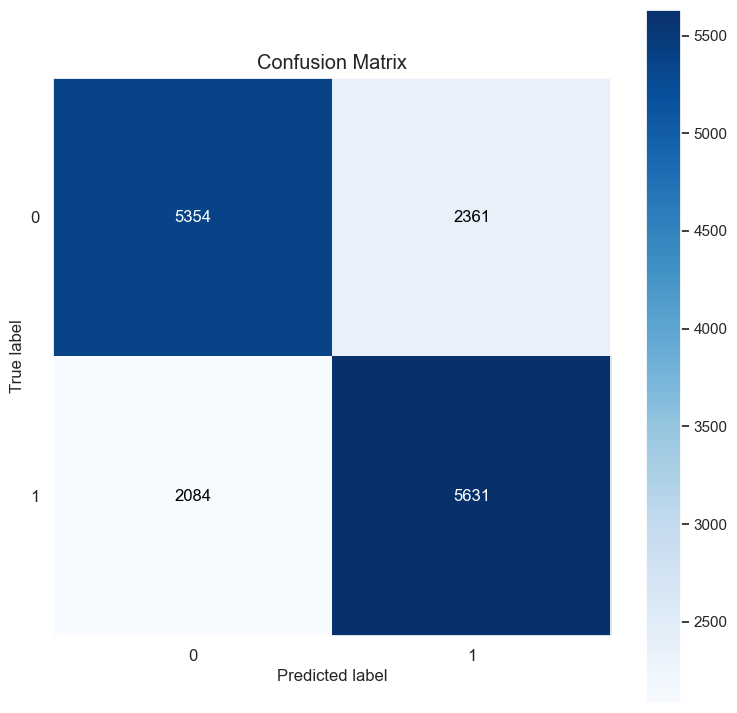

In [274]:
# Convert continuous targets to binary targets
y_test_rf_binary = np.round(y_test_rf)
yhat_rf_binary = np.round(yhat_rf)

# Accuracy
acc_rf = m.accuracy_score(y_test_rf_binary, yhat_rf_binary)
print('Accuracy: {}'.format(acc_rf))

# Balanced Accuray
balanced_acc_rf = m.balanced_accuracy_score(y_test_rf_binary, yhat_rf_binary)
print('Balanced Accuracy: {}'.format(balanced_acc_rf))

# Kappa Metrics
kappa_rf = m.cohen_kappa_score(y_test_rf_binary, yhat_rf_binary)
print('Kappa Score: {}'.format(kappa_rf))

# Classification report
print(m.classification_report(y_test_rf_binary, yhat_rf_binary))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_rf_binary, yhat_rf_binary, normalize=False, figsize=(9,9));

- All features group seems to present a better performance for this case.
- This model performed better than Logistic Regression.